In [237]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## <span style="font-family: cursive;">Прогноз цен на металлы.</span>

![Intro](data/intro.jpg)

---

## Описание проекта:
Основная задача:

- Создать модель, прогнозирующую спотовую цену на металл (в нашем случае медь) с горизонтом планирования 3 месяца. Затем аггрегировать показатели по месяцу, выводя среднюю цену периода плюс границы доверительного интервала для прогноза.

- Воссоздать модель в компактном и мобильном виде, как базовый инструмент для более глубокого анализа рынков металлов. С высокой степенью устойчивости в контексте источников данных, что продиктованно необходимостью ежедневного уточнения прогноза.

- Со звездочкой. Задеплоить микросервис на рабочий сервер, но есть нюанс, что этот момент скорее всего будет выполнен в виде подтверждения исполнения, т.к. ели будет приянто решение использовать в реальной работе, то автоматом попадет под внутреннюю разработку нынешней компании и комерческую тайну.

Выбор метрики:

- Для прогнозирования возьмем в расчет ориентир на MAE, RMSE и MAPE. С концентрацией на MAE.

- RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

- MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны, что для нас является ключевым фактором при прогнозе средних значений.

- Пороговым значением MAE примем 150-200$.

Описание датасета:

- Датасет парсится с сайта westmetall, который в свою очередь аггрегирует информацию с Лондонской биржи металлов (LME).

- Избан единственный источник данных в следствие необходимости создания бенчмарка для LME высокой степени устойчивости, что с одной стороны понижает точность прогноза (наиболее вероятно), но с другой обеспечивает надежность. 

- В данном исследовании приводится анализ единственного металла, но парсер пополняет базу данных для всех ключевых non-ferrous metalls. Данные не имеют как таковых выбросов, т.к. формируются на основании временных рядов цен и запасов металлов, отражая реальную коньюктуру рынка, но могут содержаться аномалии.

P.S. Для упрощения анализа других металлов максимально унифицировал шаблон действий. В соседних файлах будет аналитика по аллюминию, цинку, свинцу, никелю.

---

### Технический блок.

### Содержание:
- Без парсера, берем данные из базы.
- Функции для использования в исследовании

---

- Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [238]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [239]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'

    return result_row

In [240]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock_aluminium.csv', 'a') as file:
                file.write(metric)


def log_metrics_spot(metric):
    with open('./data/errors/spot_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot_aluminium.csv', 'a') as file:
                file.write(metric)

In [241]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

In [242]:
# Функция для кодирования даты
def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

---

### Часть 0.

- Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [243]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/aluminium.csv',
                parse_dates=['date'], index_col=['date'])

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3978.000000,3978.000000,3978.000000
mean,2046.630593,2009.088738,2736.952558
std,412.026724,485.259856,1741.915227
min,0.000000,0.000000,0.000000
25%,1761.125000,1778.000000,1150.131250
50%,1975.250000,1972.000000,2190.750000
75%,2260.375000,2251.375000,4564.743750
max,3984.500000,3968.000000,5492.325000


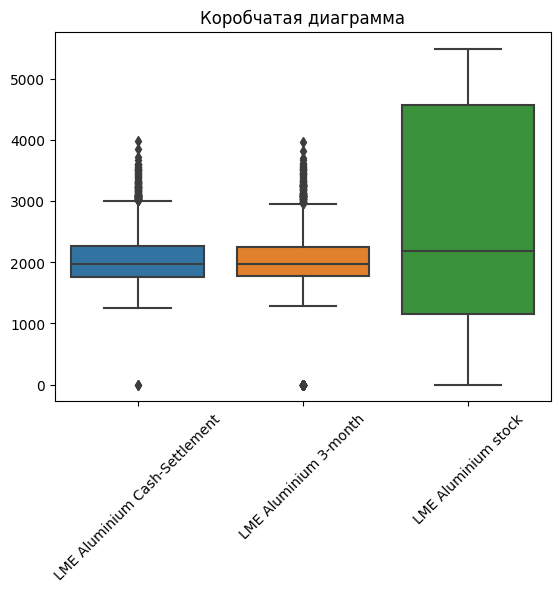

In [244]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

> Мы обнаружили аномалию - пропуск в данных

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3894.000000,3894.000000,3894.000000
mean,2029.257447,2051.925783,2773.056818
std,392.798609,390.722050,1741.430707
min,1253.500000,1288.500000,271.450000
25%,1756.125000,1787.000000,1183.187500
50%,1964.750000,1983.750000,2245.875000
75%,2236.875000,2260.375000,4568.900000
max,3984.500000,3968.000000,5492.325000


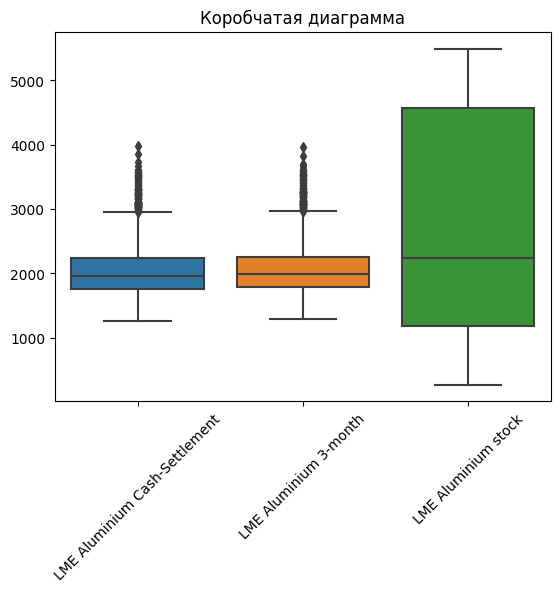

In [245]:
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

- Для последующего разложения и моделирования было принято решени о произведении интерполяции данных, итоговая точность прогноза от данных действий пострадает не сильно, учитывая, что нас не интересует дневной уровень цены

In [246]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [247]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
365,2009-01-01,1473.500000,2301.000000,2333.600000
366,2009-01-02,1492.000000,2285.666667,2338.300000
367,2009-01-03,1499.833333,2270.333333,2340.608333
368,2009-01-04,1507.666667,2255.000000,2342.916667
369,2009-01-05,1515.500000,2275.000000,2345.225000


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
85,2023-12-19,NaN,2212.0,NaN
86,2023-12-20,NaN,2240.0,NaN
87,2023-12-21,NaN,2235.0,NaN
88,2023-12-22,NaN,2230.0,NaN
89,2023-12-23,NaN,2225.0,NaN


---

#### Посмотрим на корреляцию между параметрами и целевой переменной

Диапазон планирования равен 90 дней


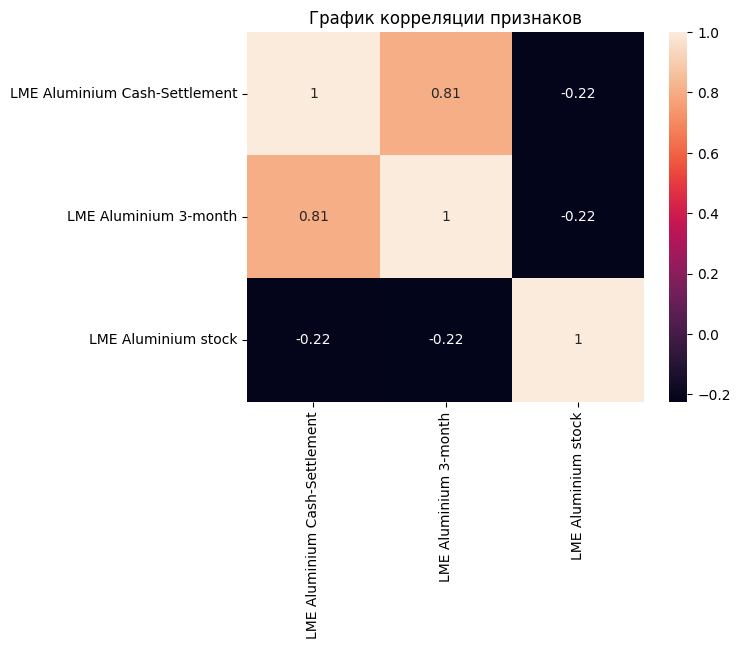

In [248]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data.iloc[:, 3].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data.iloc[:, 3].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

> Можно наблюдать высокий уровень корреляции между фьючерсной ценой и спотом, что понадобится нам потом и какую-то между запасами и спотом, что тоже лучше чем ничего.
> На основании того что у нас есть фиты с сильной корреляцией к целевой переменной, мы можем попробовать что-то большее чем стандартный набор для прогнозирования временных рядов.

---

Исходя из первичного анализа данных вырисовывается следующий план:
- Протестировать модели прогноза временных рядов для запасов и цены с последующим логированием
- Протестировать ML- методы линейной регрессии

---

#### Посмотри на распределение показателей с которыми мы будем работать

<Axes: xlabel='LME Aluminium Cash-Settlement', ylabel='Count'>

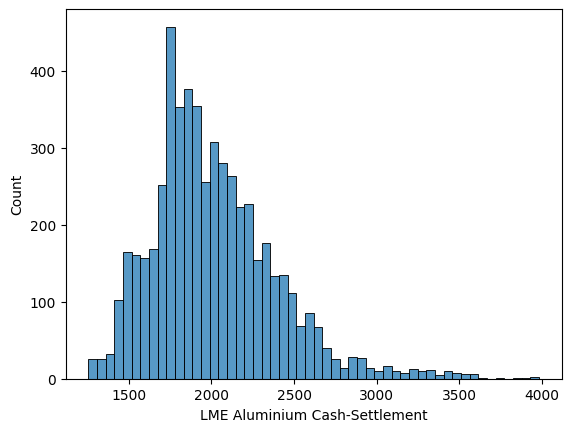

In [249]:
# Посмотрим на распределения цены и запасов
sns.histplot(data.iloc[:, 1])

По цене нормальное распределение

<Axes: xlabel='LME Aluminium stock', ylabel='Count'>

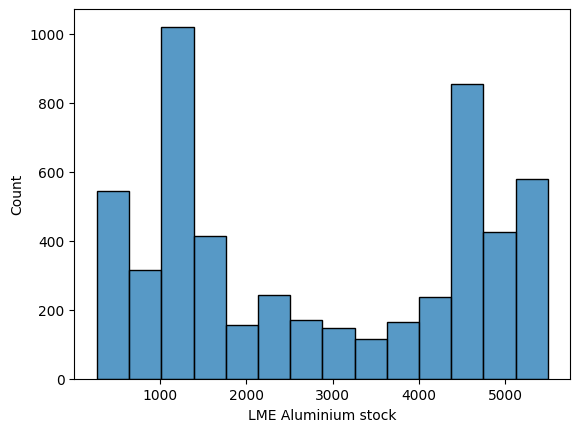

In [250]:
sns.histplot(data.iloc[:, -1])

<Axes: xlabel='LME Aluminium stock', ylabel='Count'>

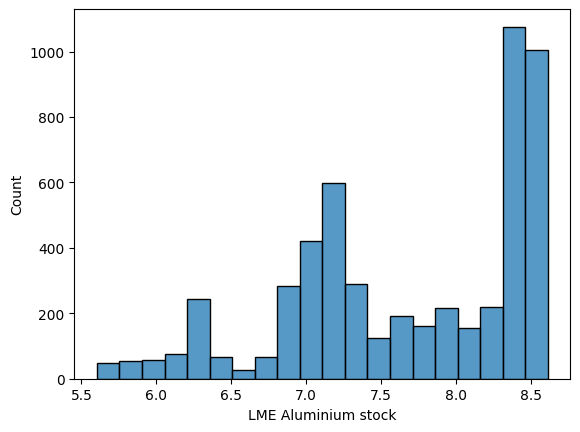

In [251]:
sns.histplot(np.log(data.iloc[:, -1]))

По запасам логнормальное, это может понадобиться в будущем (не понадобится, в итоге лучше принимать его за нормальное и не логарифмировать, но об этом позже)

---

Предварительный вывод и личные коментарии:
- Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.

- Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.

- Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

### Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [252]:
# Будем прогнозировать временной ряд LME Copper stock и
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data.iloc[:, 2]
spot = working_data.iloc[:, 0]

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

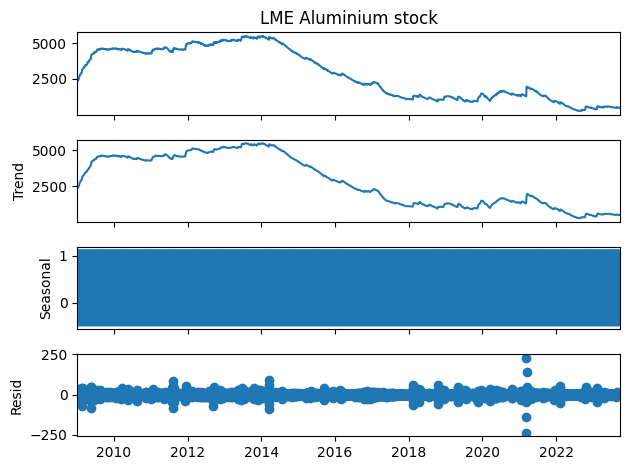

In [253]:
# Произвведем декомпозицию ряда
decompose_stock.plot()
plt.show()

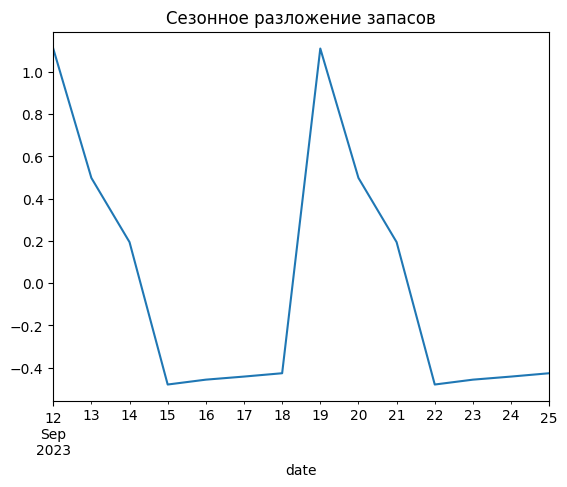

In [254]:
# Приблизим сезонность
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

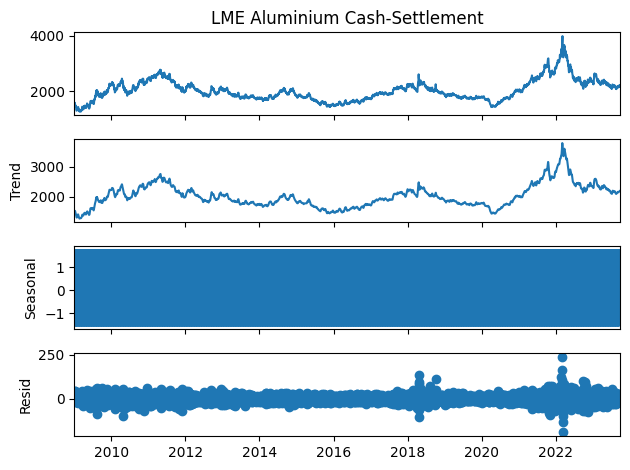

In [255]:
# Для цены
decompose_spot.plot()
plt.show()

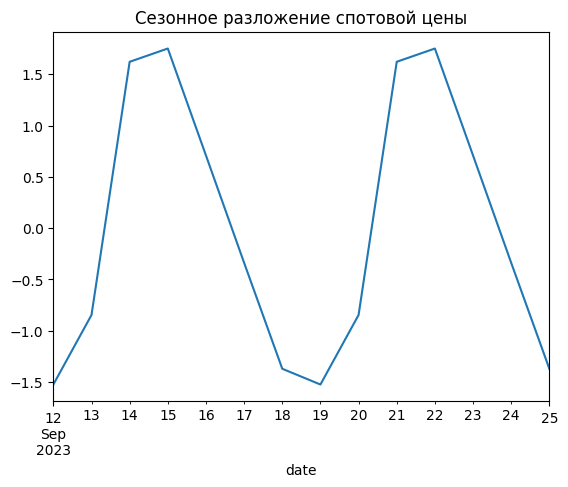

In [256]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -10.211842733493647, 'crit_value (5%)': -2.8620802901611566}
Единичных корней нет, ряд стационарен
{'p_value': -22.915553727523772, 'crit_value (5%)': -2.8620785786396556}


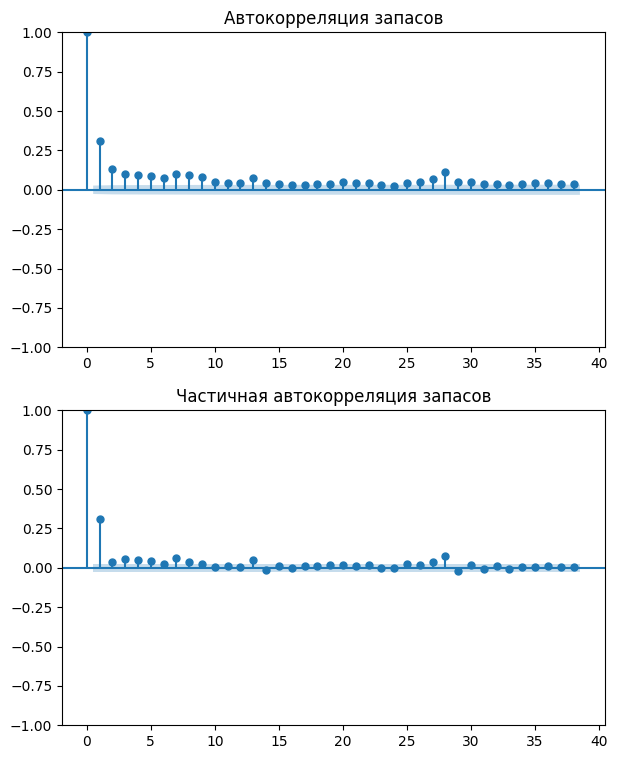

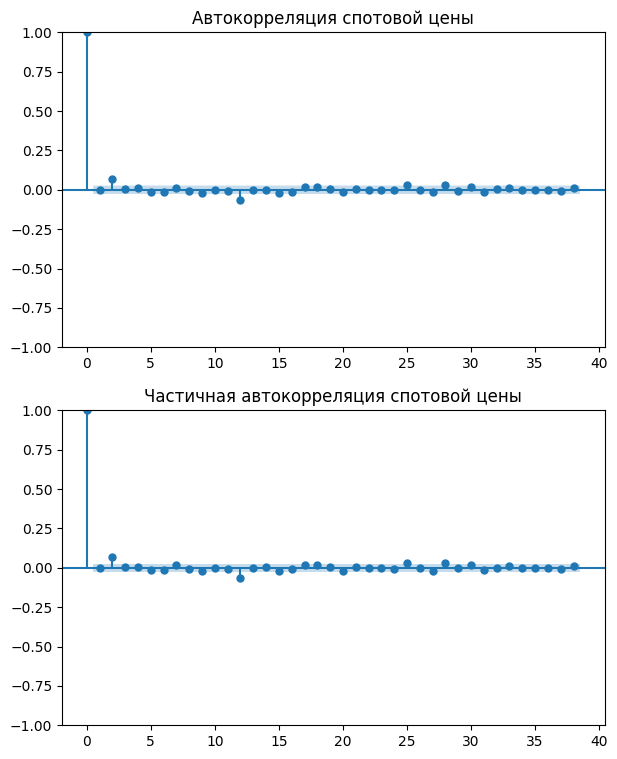

In [257]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 2 (так же исходя из pacf)

In [258]:
p_stock = 1
d_stock = 0
q_stock = 0

p_spot = 2
d_spot = 0
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [259]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [260]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [261]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [262]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 13.539
MAE для AR-baseline-stock: 11.278
MAPE для AR-baseline-stock: 2.1999999999999997%


Дубликат значения metric. Не сохраняем.
RMSE для AR-baseline-spot: 38.415
MAE для AR-baseline-spot: 32.112
MAPE для AR-baseline-spot: 1.5%


Дубликат значения metric. Не сохраняем.


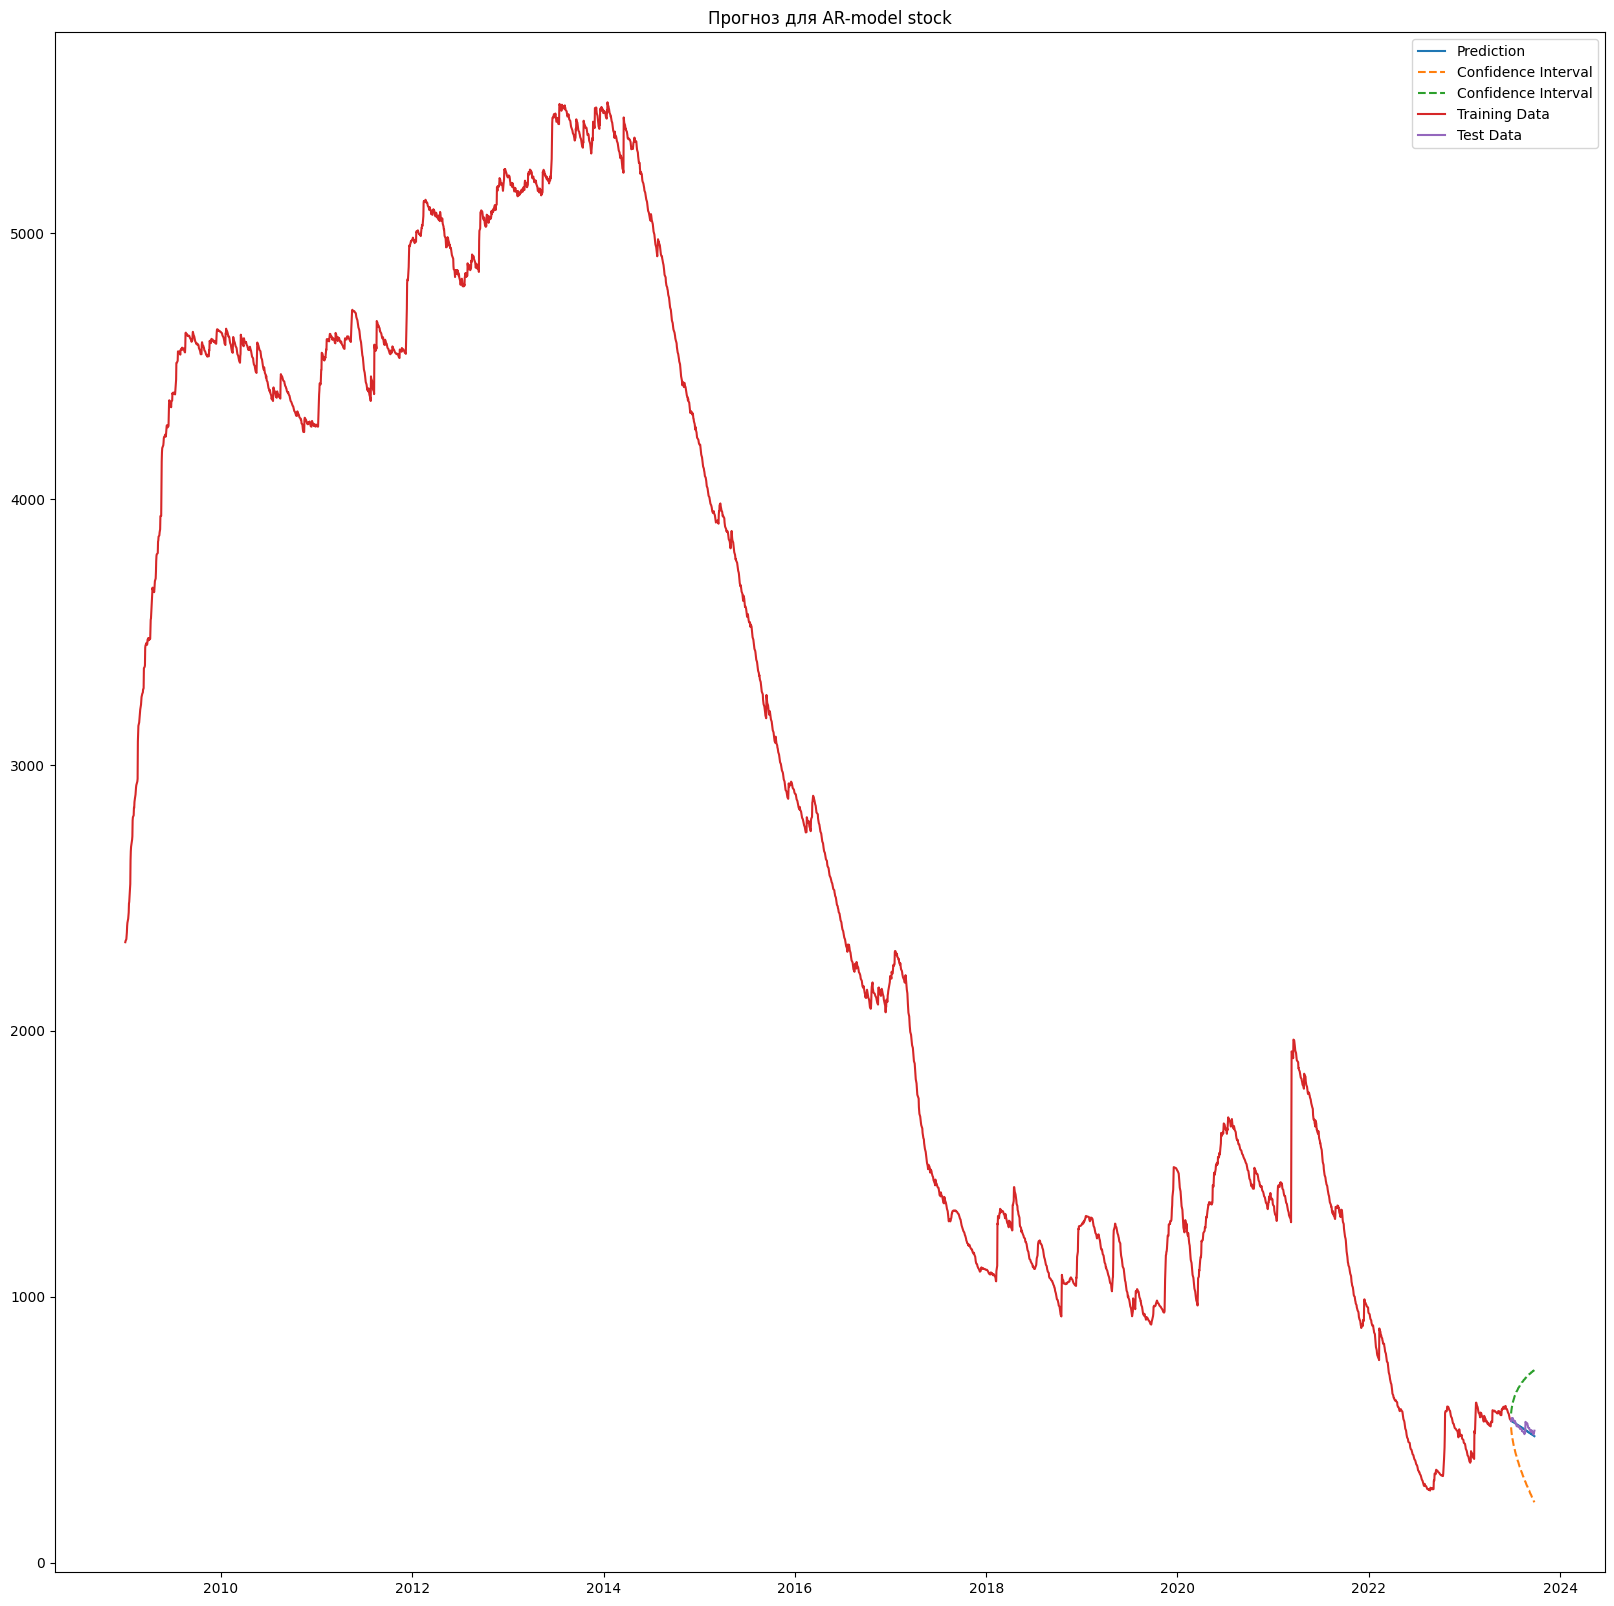

In [263]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

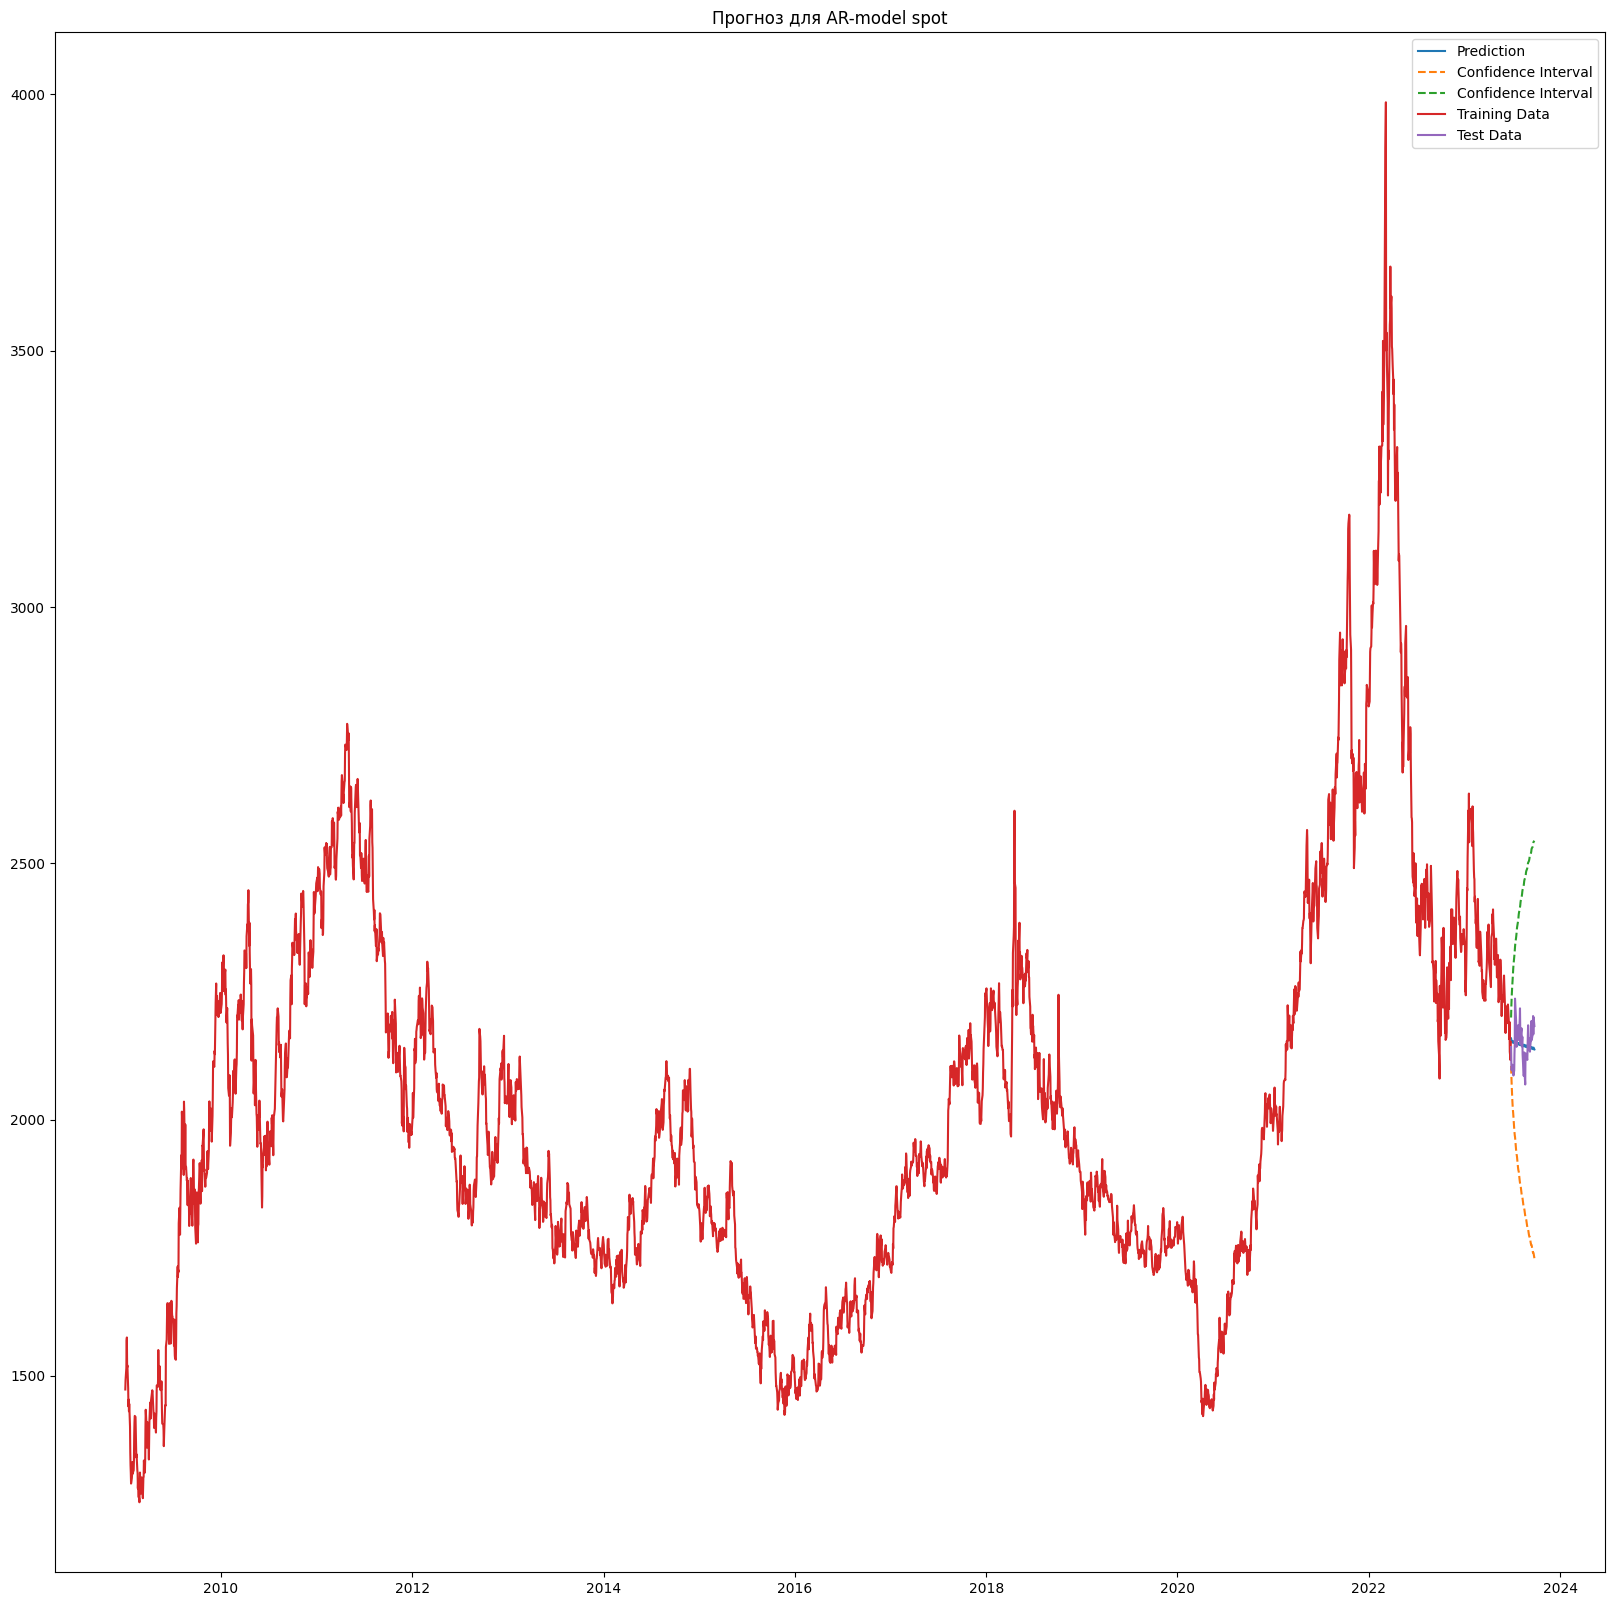

In [264]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьма широк
> Что говорит о вероято слабой прогностической способности в бою (если бы мы ставили целью прогноз именно запасов).

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1, d=1)

In [265]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [266]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 37.04
MAE для ARIMA-stock: 32.219
MAPE для ARIMA-stock: 6.4%


RMSE для ARIMA-spot: 40.249
MAE для ARIMA-spot: 34.197
MAPE для ARIMA-spot: 1.6%




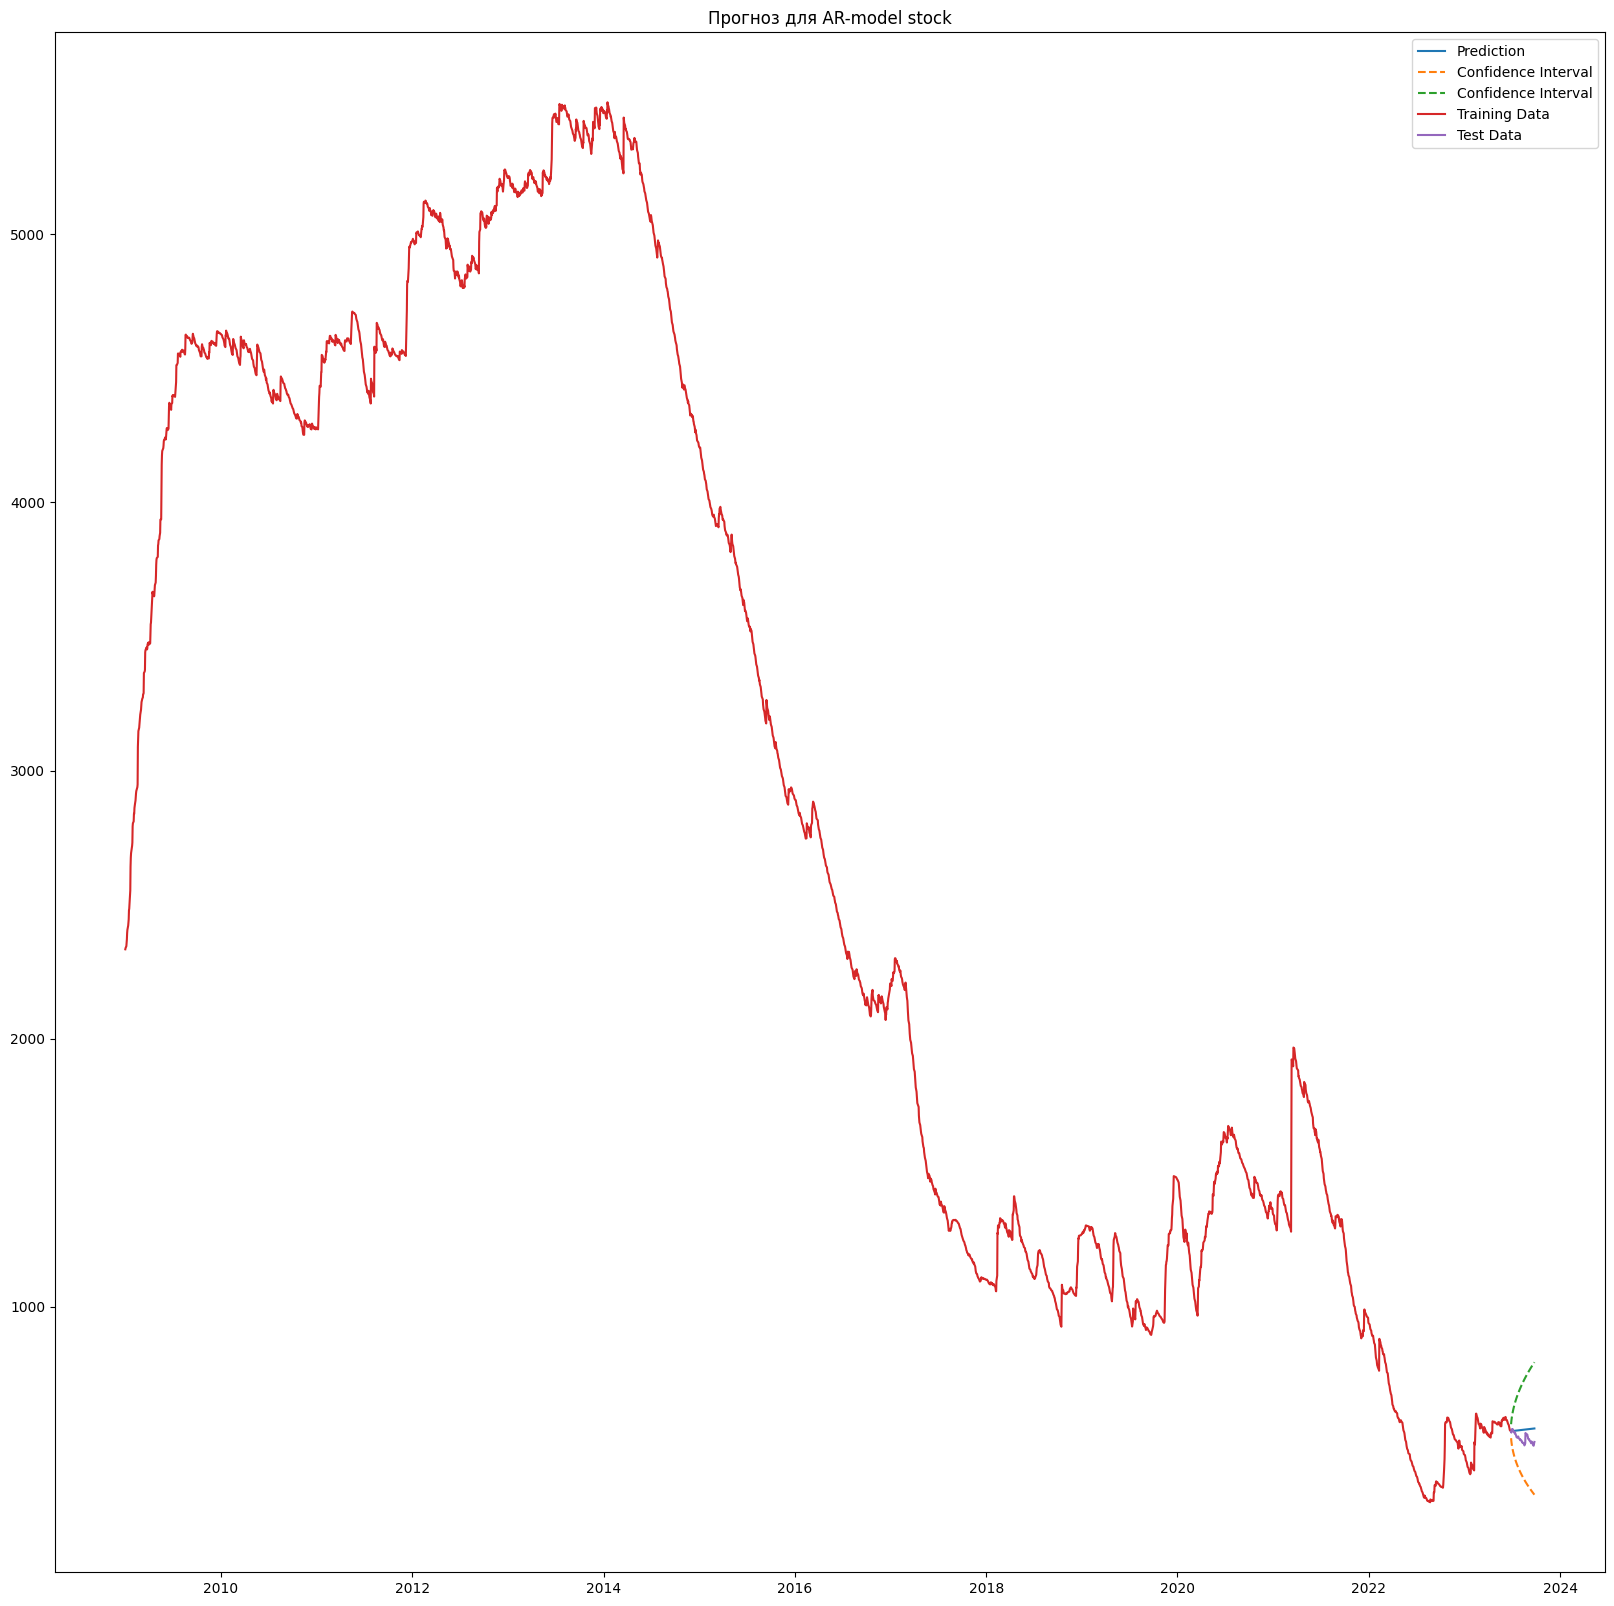

In [267]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

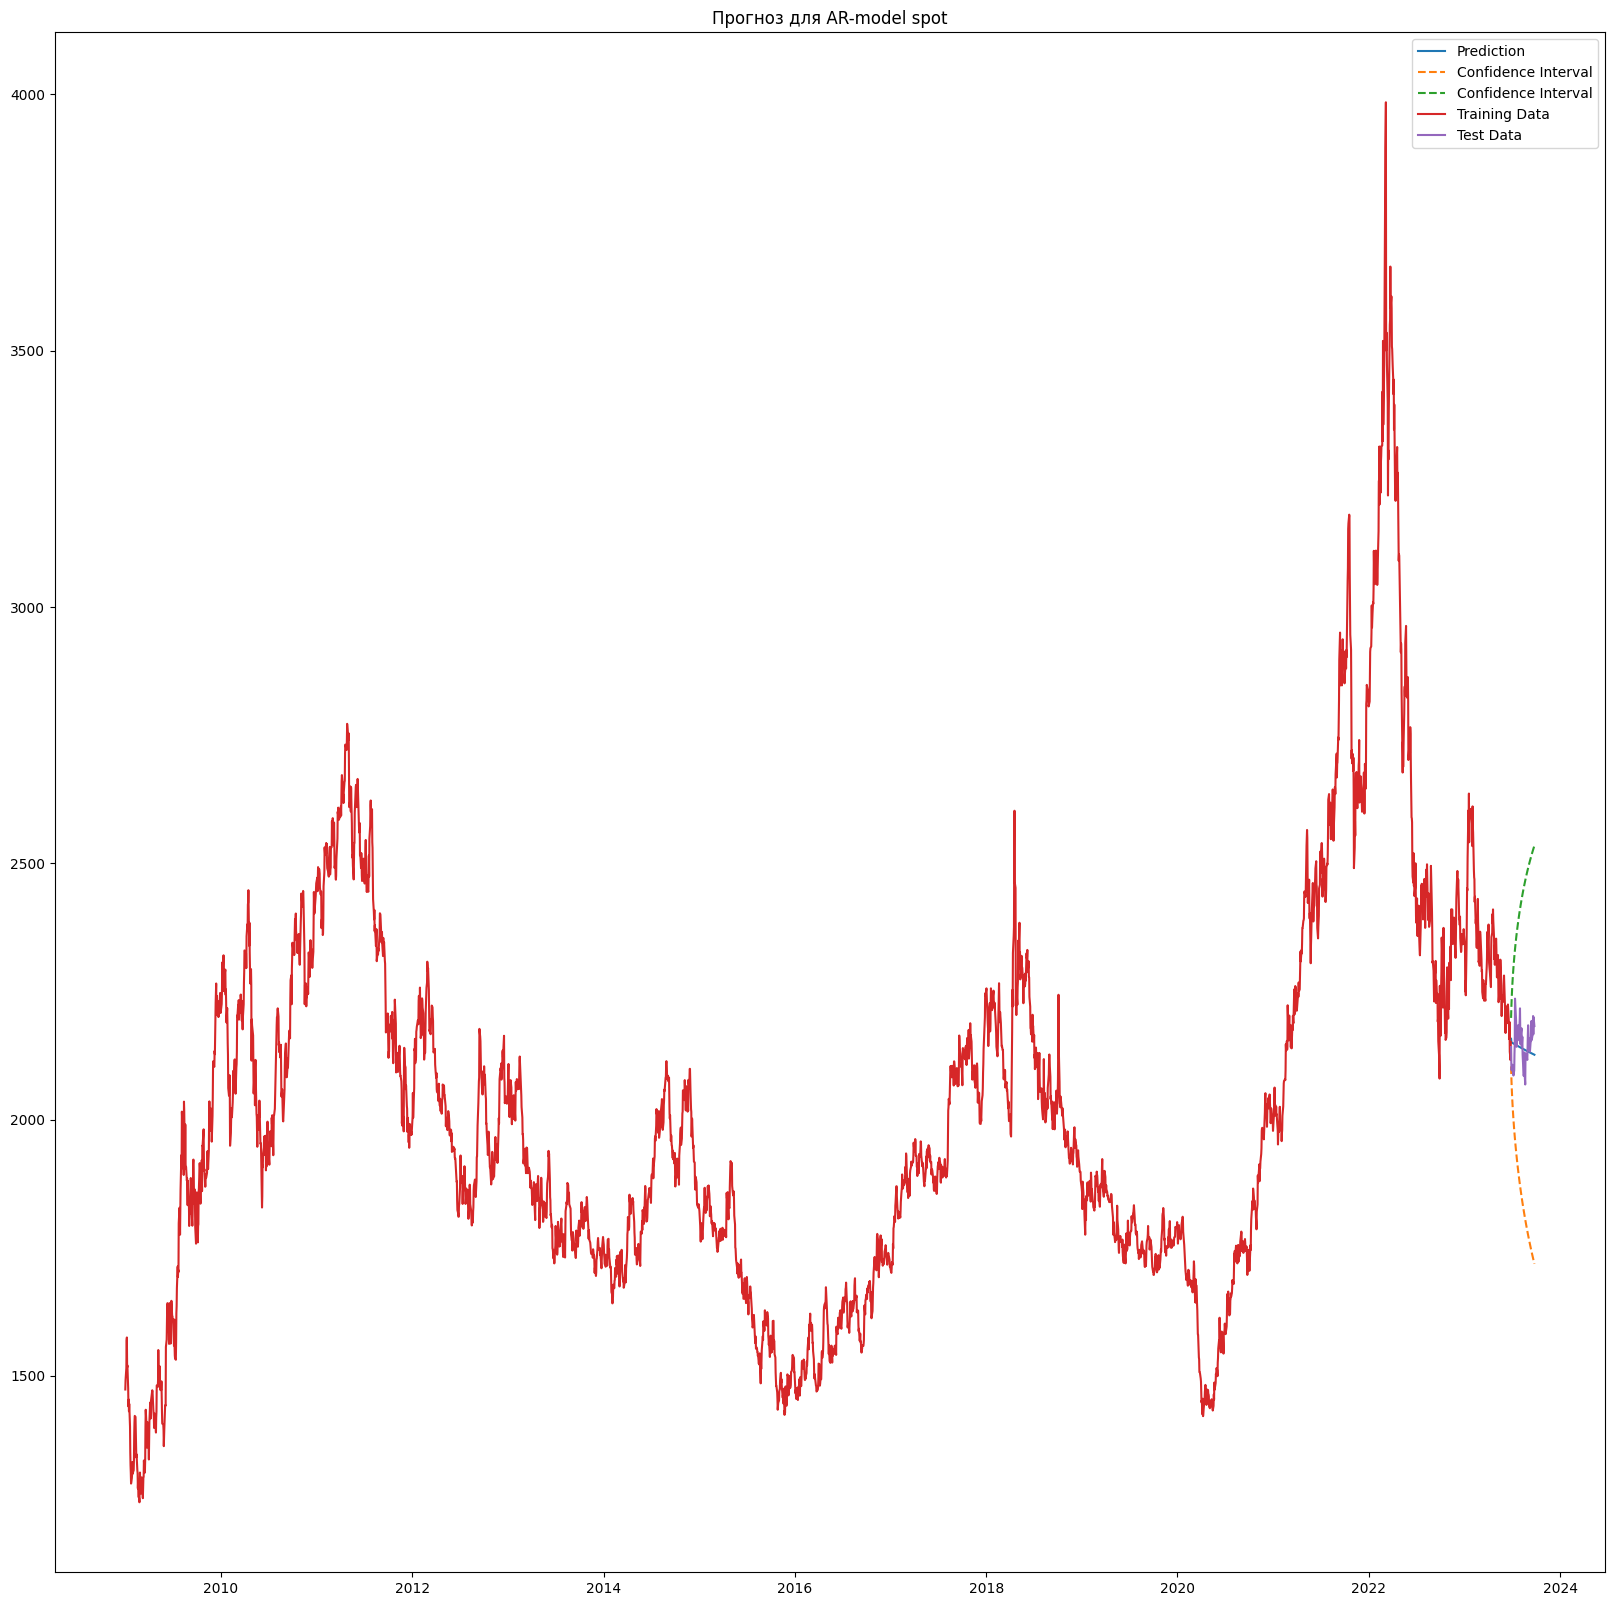

In [268]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [269]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=45456.123, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=43788.274, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=45114.160, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43177.405, Time=1.45 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.05 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=43562.677, Time=1.09 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=43177.776, Time=1.73 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=43177.173, Time=2.04 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=43788.823, Time=0.87 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=inf, Time=7.16 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=3.59 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=43208.435, Time=1.29 sec
 ARIMA(2,1,1)(2,1,0)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5291
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -21579.204
Date:                           Tue, 26 Sep 2023   AIC                          43172.408
Time:                                   11:45:33   BIC                          43218.414
Sample:                               01-01-2009   HQIC                         43188.487
                                    - 06-27-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2599      0.003    100.418      0.000       0.255       0.265
ar.L2          0.0084      0.007      1.291      0.197      -0.004       0.021
ar.L3          0.0284      0.016      1.762      0.078      -0.003       0.060
ar.L4          0.0240      0.016      1.513      0.130      -0.007       0.055
ar.S.L7       -0.6302      0.003   -192.002      0.000      -0.637      -0.624
ar.S.L14      -0.3323      0.003   -100.623      0.000      -0.339      -0.326
sigma2       206.5976      0.600    344.070      0.000     205.421     207.774
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2216123.66
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             5.44
Prob(H) (two-sided):                  0.10   Kurtosis:                       102.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [270]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.92 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=52205.796, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=50757.360, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=52207.291, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=50126.519, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.05 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=50124.739, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=50755.820, Time=0.24 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=5.89 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=50126.551, Time=1.45 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=50120.058, Time=2.34 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=50746.756, Time=1.18 sec
 ARIMA(1,1,1)(2,1,1)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5291
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -25039.749
Date:                           Tue, 26 Sep 2023   AIC                          50089.498
Time:                                   11:46:44   BIC                          50122.359
Sample:                               01-01-2009   HQIC                         50100.983
                                    - 06-27-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0059      0.009      0.681      0.496      -0.011       0.023
ar.L2          0.0859      0.009      9.543      0.000       0.068       0.104
ar.S.L7       -0.6566      0.006   -106.104      0.000      -0.669      -0.644
ar.S.L14      -0.3326      0.005    -65.619      0.000      -0.343      -0.323
sigma2       765.7289      4.416    173.394      0.000     757.074     774.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            178803.65
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [271]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [272]:
with open('./data/ar_stock_al.pkl', 'wb') as pkl_file:
    pickle.dump(model_stock.get_params(), pkl_file)

In [273]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [274]:
with open('./data/ar_spot_al.pkl', 'wb') as pkl_file:
    pickle.dump(model_spot.get_params(), pkl_file)

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### ARIMA - по подобранным параметрам

In [275]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [276]:
# Используем модель ARIMA
pmarima_model_stock = ARIMA(
    train_stock, order=order_stock,
    seasonal_order=seasonal_order_stock).fit()

pmarima_model_spot = ARIMA(
    train_spot, order=order_spot,
    seasonal_order=seasonal_order_spot).fit()

# Прогноз
pred_pmarima_stock = pmarima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_pmarima_spot = pmarima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Доверительные интервалы
forecast_stock = pmarima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = pmarima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_pmarima_stock, name='PMARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_pmarima_spot, name='PMARIMA-spot'))

RMSE для PMARIMA-stock: 113.181
MAE для PMARIMA-stock: 97.02
MAPE для PMARIMA-stock: 19.3%


Дубликат значения metric. Не сохраняем.
RMSE для PMARIMA-spot: 100.894
MAE для PMARIMA-spot: 87.51
MAPE для PMARIMA-spot: 4.1000000000000005%


Дубликат значения metric. Не сохраняем.


> Ухудшение метрик, усложнение можели не идет на пользу.

---

### SARIMAX

In [277]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10932D+00    |proj g|=  2.02103D-02


 This problem is unconstrained.



At iterate    5    f=  4.08719D+00    |proj g|=  7.47298D-02

At iterate   10    f=  4.07847D+00    |proj g|=  5.18454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     15      1     0     0   6.716D-06   4.078D+00
  F =   4.0784736221949229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76678D+00    |proj g|=  9.65965D-03

At iterate    5    f=  4.73264D+00    |proj g|=  1.28865D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   1.727D-05   4.733D+00
  F =   4.7325172766233292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSE для SARIMAX-stock: 113.181
MAE для SARIMAX-stock: 97.02
MAPE для SARIMAX-stock: 19.3%


Дубликат значения metric. Не сохраняем.

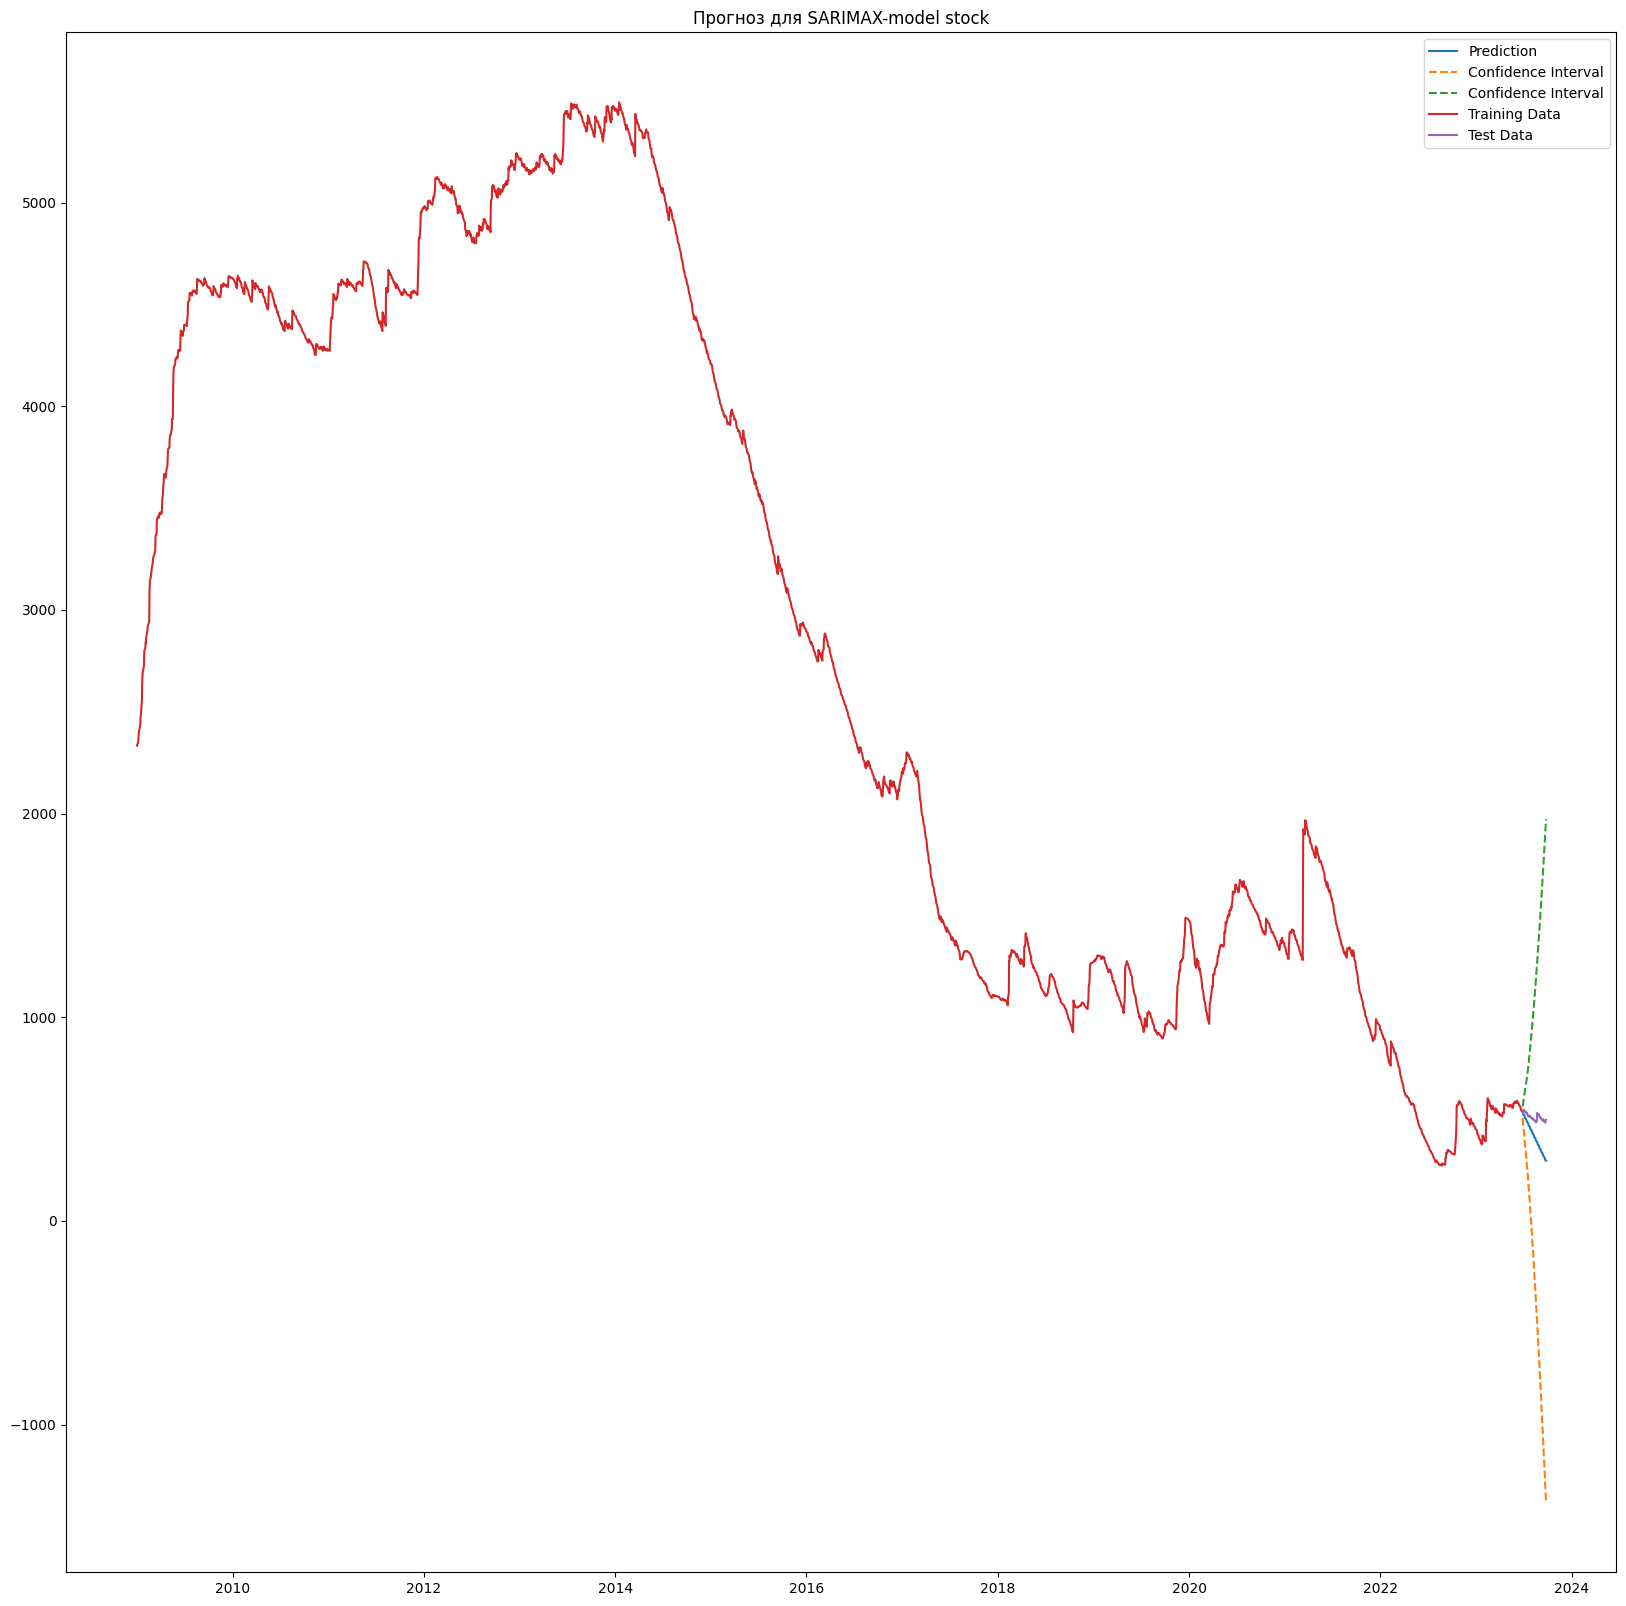

In [278]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

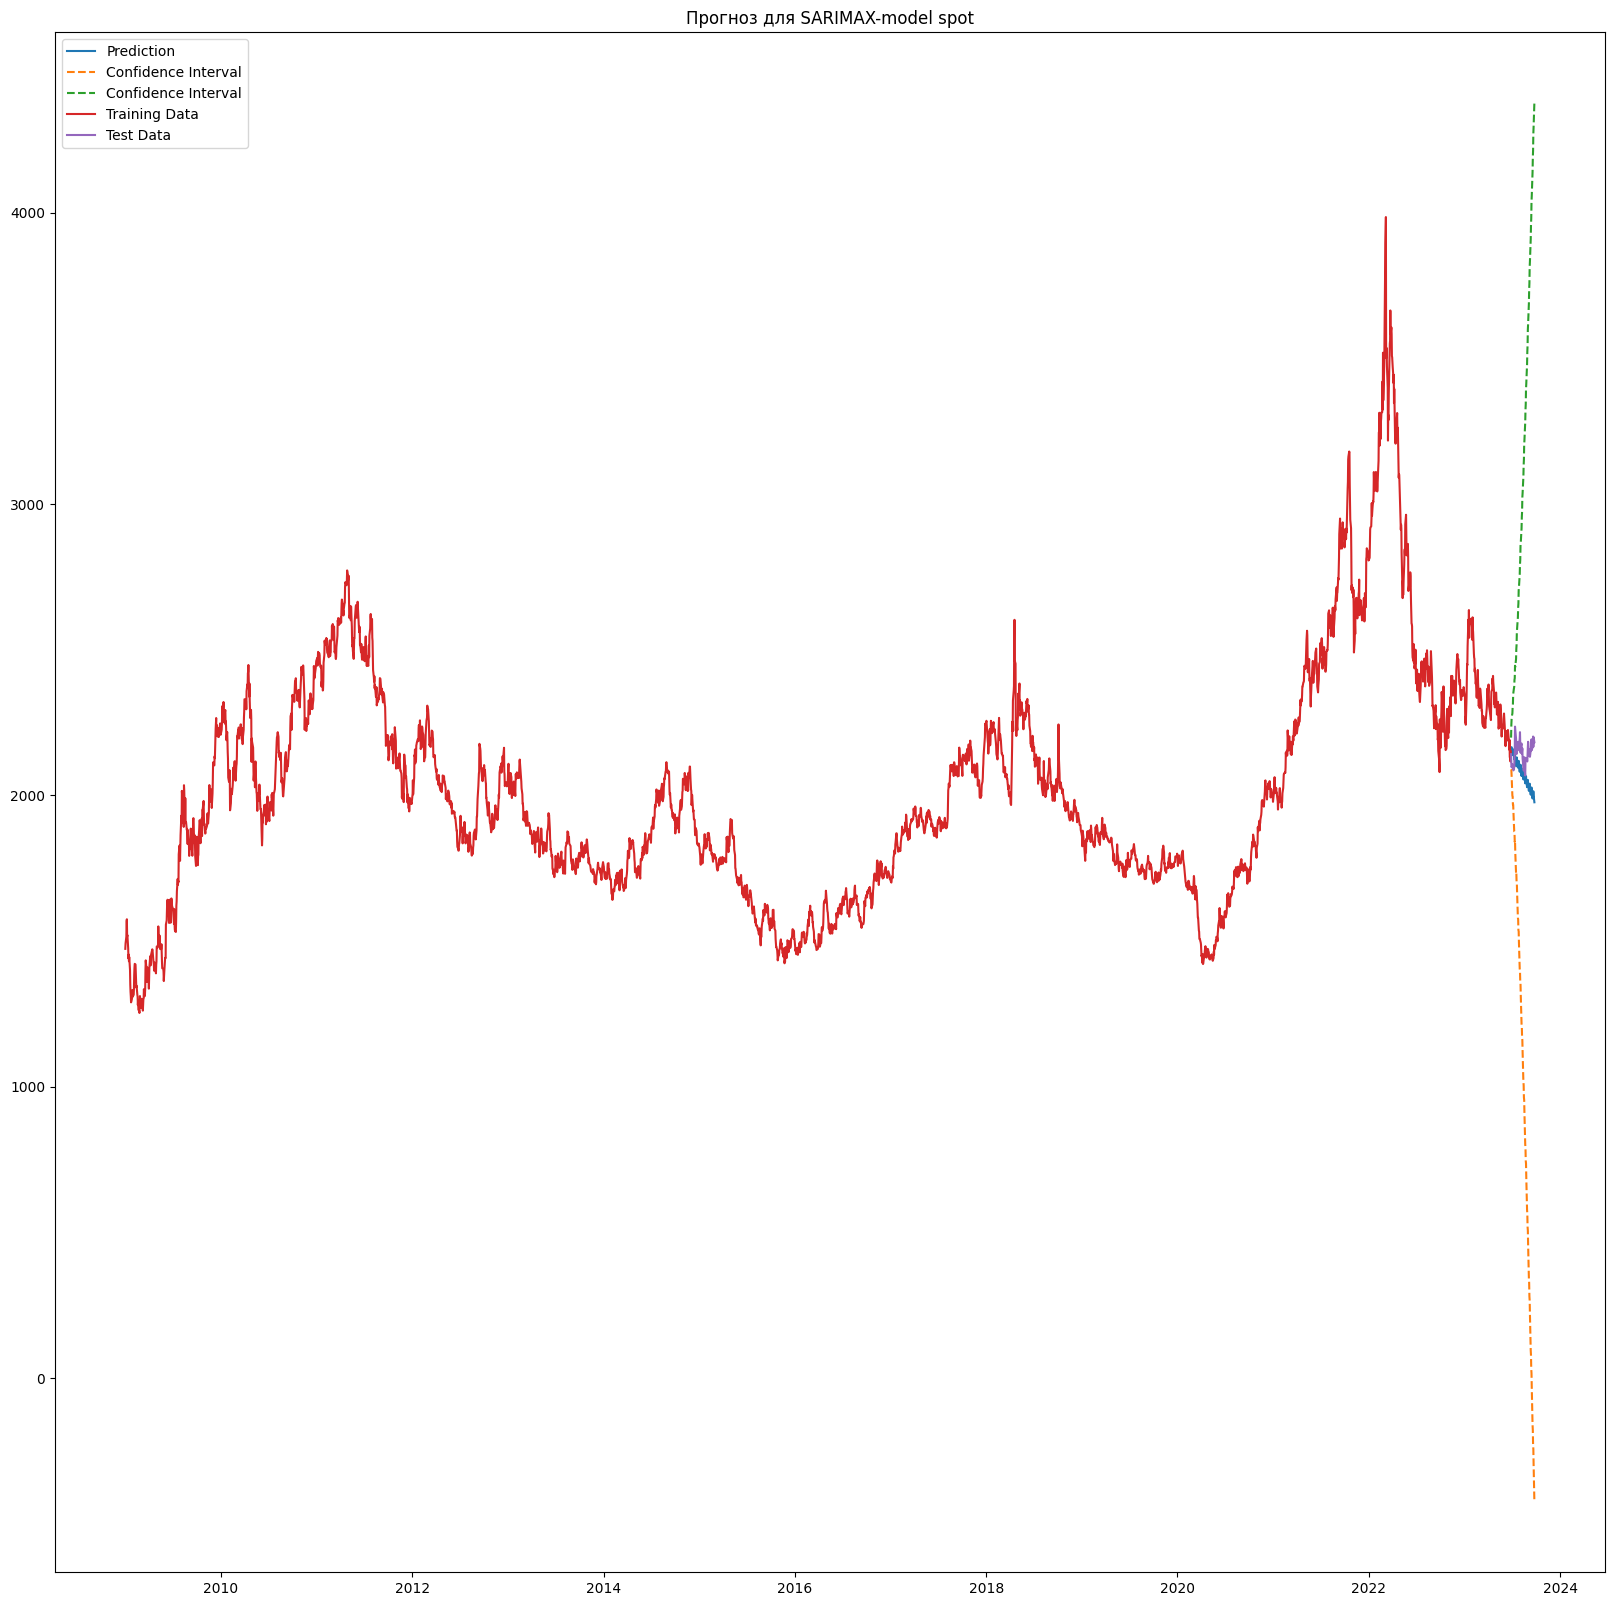

In [279]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [280]:
# Инициализируем модель
garch_stock = arch_model(
    train_stock, lags=1, vol='GARCH',
    p=1, q=1, rescale=True).fit()

garch_spot = arch_model(
    train_spot, lags=1, vol='GARCH',
    p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(
    start=str(train_stock.index[-1]), horizon=90)
pred_garch_spot = garch_spot.forecast(
    start=str(train_spot.index[-1]), horizon=90)

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(
        f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 51592809261.87943
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2879215548.4096813
Iteration:      3,   Func. Count:     20,   Neg. LLF: 14664479196.513447
Iteration:      4,   Func. Count:     27,   Neg. LLF: 8502843477325.658
Iteration:      5,   Func. Count:     34,   Neg. LLF: 23411.495967923787
Iteration:      6,   Func. Count:     41,   Neg. LLF: 20212.988115947242
Iteration:      7,   Func. Count:     46,   Neg. LLF: 21504.19726875116
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2213288.1172572626
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3325678545586.3384
Iteration:     10,   Func. Count:     82,   Neg. LLF: 63526693429368.25
Iteration:     11,   Func. Count:     97,   Neg. LLF: 32541.90030924003
Iteration:     12,   Func. Count:    102,   Neg. LLF: 32344.310580149704
Iteration:     13,   Func. Count:    107,   Neg. LLF: 31227.519000046657
Iteration:     14,   Func. Count:    112,   Neg. LLF: 20

> В будущем нам пригодится SARIMAX, хоть сама модель и не подошла, но мы будем прогнозировать дисперсию и накладывать на результаты прогноза спота и запасов.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [281]:
# Посмотрим на картины прогнозов для моделей показавших лучший результат
# с использованием авторегрессии
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-11    485.001989
2023-09-12    485.853410
2023-09-13    484.617613
2023-09-14    483.640002
2023-09-15    482.316683
2023-09-16    481.670907
2023-09-17    481.025087
2023-09-18    480.379225
2023-09-19    481.230030
2023-09-20    479.993615
2023-09-21    479.015385
2023-09-22    477.691449
2023-09-23    477.045054
2023-09-24    476.398617
2023-09-25    475.752137
Freq: D, dtype: float64

2023-09-11    545.082581
2023-09-12    545.196267
2023-09-13    545.309948
2023-09-14    545.423623
2023-09-15    545.537292
2023-09-16    545.650956
2023-09-17    545.764614
2023-09-18    545.878267
2023-09-19    545.991914
2023-09-20    546.105556
2023-09-21    546.219192
2023-09-22    546.332823
2023-09-23    546.446448
2023-09-24    546.560067
2023-09-25    546.673681
Freq: D, dtype: float64

In [282]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему
# выбор пал на базовую модель, дело в том, что различие в метриках
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее ()
best_ts = pred_ar_stock

In [283]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-16    481.670907
2023-09-17    481.025087
2023-09-18    480.379225
2023-09-19    481.230030
2023-09-20    479.993615
2023-09-21    479.015385
2023-09-22    477.691449
2023-09-23    477.045054
2023-09-24    476.398617
2023-09-25    475.752137
dtype: float64

In [284]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[[working_data.columns.to_list()[0], working_data.columns.to_list()[
        1]]], stock_column],
    axis=1).rename(columns={0: working_data.columns.to_list()[2]})

display(working_data.head(), working_data.tail())

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2009-01-01,1473.500000,2301.000000,2333.600000
2009-01-02,1492.000000,2285.666667,2338.300000
2009-01-03,1499.833333,2270.333333,2340.608333
2009-01-04,1507.666667,2255.000000,2342.916667
2009-01-05,1515.500000,2275.000000,2345.225000


,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-21,2166.500000,2175.000000,483.55
2023-09-22,2199.500000,2168.333333,482.30
2023-09-23,2193.833333,2161.666667,487.05
2023-09-24,2188.166667,2155.000000,491.80
2023-09-25,2182.500000,2191.500000,496.55


In [285]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]

In [286]:
# Тренировочная эндогенная
endog_train = train.iloc[:, 0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:, 1:]
exog_test = test.iloc[:, 1:]
# exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:, 0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [287]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [288]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(
    start=start, end=end, exog=exog_test)

In [289]:
log_metrics_spot(metrics_calculation(
    pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 38.069
MAE для ARIMAX-spot: 30.554
MAPE для ARIMAX-spot: 1.4000000000000001%


Дубликат значения metric. Не сохраняем.


> Хуже чем baseline.

----

### Попробуем методы МО в контексте прогноза запасов

In [290]:
# Реинициализируем выборку
working_data_ml = working_data.reset_index()

working_data_ml = working_data_ml.drop(
    columns=working_data_ml.columns.to_list()[1])

working_data_ml['date'] = working_data_ml['date'].apply(date_format_reverse)

# Сформируем трейн/тест для общего случая
train_ml = working_data_ml[:len(train_spot)]
test_ml = working_data_ml[-len(test_spot):]

# Разобьем на обучающую/тестовую подвыборки
X_train_ml = train_ml.iloc[:, :2]
y_train_ml = train_ml.iloc[:, 2]

X_test_ml = test_ml.iloc[:, :2]
y_test_ml = test_ml.iloc[:, 2]

---

#### Linear Regression

In [291]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model_ml = LinearRegression(
    n_jobs=-1
)

lr_model_ml.fit(X_train_ml, y_train_ml)

pred_lr_model_ml = lr_model_ml.predict(X_test_ml)
pred_lr_model_ml = pd.Series(pred_lr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_lr_model_ml, name='LR-model'))

RMSE для LR-model: 301.046
MAE для LR-model: 300.33
MAPE для LR-model: 59.0%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

#### Decision Tree regressor for stock

In [292]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_ml = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_ml.fit(X_train_ml, y_train_ml)
grid_search_dt_ml.best_params_

# Modeling
dt_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)
dt_model.fit(X_train_ml, y_train_ml)

pred_dt_spot_ml = dt_model.predict(X_test_ml)
pred_dt_spot_ml = pd.Series(pred_dt_spot_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_dt_spot_ml, name='DT-model'))

RMSE для DT-model: 21.388
MAE для DT-model: 18.489
MAPE для DT-model: 3.6999999999999997%


Дубликат значения metric. Не сохраняем.


> Незначительно лучше baseline.

---

#### RandomForestRegressor для stock.

In [293]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr_ml = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr_ml.fit(X_train_ml, y_train_ml)
grid_search_rfr_ml.best_params_

# Modelling
rfr_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

rfr_model.fit(X_train_ml, y_train_ml)

pred_rfr_model_ml = rfr_model.predict(X_test_ml)
pred_rfr_model_ml = pd.Series(pred_rfr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_rfr_model_ml, name='RFR-model'))

RMSE для RFR-model: 31.982
MAE для RFR-model: 28.307
MAPE для RFR-model: 5.6000000000000005%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

----

### Gradient_boost stock

In [294]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr_ml = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr_ml.fit(X_train_ml, y_train_ml)
grid_search_gbr_ml.best_params_

# Modelling
gbr_model_ml = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)

gbr_model_ml.fit(X_train_ml, y_train_ml)

pred_gbr_model_ml = gbr_model_ml.predict(X_test_ml)
pred_gbr_model_ml = pd.Series(pred_gbr_model_ml, test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_gbr_model_ml, name='GBR-model_full'))

RMSE для GBR-model_full: 36.087
MAE для GBR-model_full: 32.947
MAPE для GBR-model_full: 6.6000000000000005%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

### Stacking

In [295]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor_ml = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor_ml.fit(X_train_ml, y_train_ml)

# Получаем предсказания
predictions_ml = stacking_regressor_ml.predict(X_test_ml)

log_metrics_stock(metrics_calculation(
    y_test_ml, predictions_ml, name='Stacking'))

RMSE для Stacking: 578.337
MAE для Stacking: 554.765
MAPE для Stacking: 108.2%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

### Посмотрим на результаты моделирования запасов

In [296]:
pd.read_csv('./data/errors/stock_aluminium.csv').sort_values(by='mae')

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,AR-baseline-stock,13.539,11.278,2.2
5,2023-09-26 00:00:00,DT-model,21.388,18.489,3.7
1,2023-09-26 00:00:00,ARIMA-stock,30.948,26.628,5.3
6,2023-09-26 00:00:00,RFR-model,31.982,28.307,5.6
9,2023-09-26 00:00:00,ARIMA-stock,37.040,32.219,6.4
7,2023-09-26 00:00:00,GBR-model_full,36.087,32.947,6.6
2,2023-09-26 00:00:00,PMARIMA-stock,113.181,97.020,19.3
3,2023-09-26 00:00:00,SARIMAX-stock,113.181,97.020,19.3
4,2023-09-26 00:00:00,LR-model,301.046,300.330,59.0
8,2023-09-26 00:00:00,Stacking,578.337,554.765,108.2


> Вывод: Несмотря на небольшое превосходство дерева решений, был принят выбор в сторону AR-baseline в виду того, что:
> 1. Запасы имеют низкую корреляцию с целевой переменной, а следовательно точность их прогнозирования не значительно повлияет на финальный результат.
> 2. При моделировании запасов через дерево, мы опираемся на факторы, которые (spoiler) в последствии будут участвовать в прогнозах цен, что может привнести шум в прогноз.

---

## Часть 2.

#### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [297]:
exp_train = train.reset_index(names='date')
exp_test = test.reset_index(names='date')

exp_train['date'] = exp_train['date'].apply(date_format_reverse)
exp_test['date'] = exp_test['date'].apply(date_format_reverse)

In [298]:
# Сформируем трейн/тест для спота
X_train = exp_train.drop(exp_train.columns.tolist()[1], axis=1)
y_train = exp_train[exp_train.columns.tolist()[1]]

X_test = exp_test.drop(exp_test.columns.tolist()[1], axis=1)
y_test = exp_test[exp_test.columns.tolist()[1]]

---

#### Linear Regression

In [299]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
pred_lr_model = pd.Series(pred_lr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 148.705
MAE для LR-model: 135.679
MAPE для LR-model: 6.4%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

#### Decision Tree regressor

In [300]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [301]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

# Законсервируем модель на будущее
with open('./data/decision_tree_al.pkl', 'wb') as input:
    pickle.dump(dt_model, input)

dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
pred_dt_spot = pd.Series(pred_dt_spot, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 251.193
MAE для DT-model: 248.41
MAPE для DT-model: 11.600000000000001%


Дубликат значения metric. Не сохраняем.


> Хуже baseline, но лучшая из представленных ниже.

---

#### Decision Tree regressor (only futures)

In [302]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_s = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_s.fit(X_train.iloc[:, :-1], y_train)
grid_search_dt_s.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [303]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_s.best_params_,
    random_state=42
)
dt_model_s.fit(X_train.iloc[:, :-1], y_train)

pred_dt_spot_s = dt_model_s.predict(X_test.iloc[:, :-1])
pred_dt_spot_s = pd.Series(pred_dt_spot_s, index=test.index)
log_metrics_spot(metrics_calculation(
    y_test, pred_dt_spot_s, name='DT_simple-model'))

RMSE для DT_simple-model: 251.193
MAE для DT_simple-model: 248.41
MAPE для DT_simple-model: 11.600000000000001%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [304]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(X_train.iloc[:, :2], y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 500}

In [305]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
srfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

srfr_model.fit(X_train.iloc[:, :2], y_train)

pred_srfr_model = srfr_model.predict(X_test.iloc[:, :2])
pred_srfr_model = pd.Series(pred_srfr_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_srfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 221.13
MAE для RFR-model_no_stock: 217.877
MAPE для RFR-model_no_stock: 10.2%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [306]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 500}

In [307]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
pred_rfr_model = pd.Series(pred_rfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 221.047
MAE для RFR-model: 217.793
MAPE для RFR-model: 10.2%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

----

### Gradient_boost stock + futures

In [308]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)
grid_search_gbr.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [309]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)

gbr_model.fit(X_train, y_train)

pred_gbr_model = gbr_model.predict(X_test)
pred_gbr_model = pd.Series(pred_gbr_model, test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbr_model, name='GBR-model_full'))

RMSE для GBR-model_full: 117.175
MAE для GBR-model_full: 103.99
MAPE для GBR-model_full: 4.9%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

----

### Gradient_boost futures

In [310]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbrs = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_gbrs.fit(X_train.iloc[:, :2], y_train)
grid_search_gbrs.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [311]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbrs_model = GradientBoostingRegressor(
    **grid_search_gbrs.best_params_,
    random_state=42,
)

gbrs_model.fit(X_train.iloc[:, :2], y_train)

pred_gbrs_model = gbrs_model.predict(X_test.iloc[:, :2])
pred_gbrs_model = pd.Series(pred_gbrs_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbrs_model, name='GBR-model_futures'))

RMSE для GBR-model_futures: 117.764
MAE для GBR-model_futures: 102.495
MAPE для GBR-model_futures: 4.8%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

### Stacking

In [312]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 210.127
MAE для Stacking: 190.611
MAPE для Stacking: 8.9%


Дубликат значения metric. Не сохраняем.


> Хуже baseline.

---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250$ на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)


In [313]:
# Посмотрим на модели показавшие наилучший результат по MAE
errors_spot = pd.read_csv('./data/errors/spot_aluminium.csv', sep=',')
errors_spot.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,ARIMAX-spot,38.069,30.554,1.4
1,2023-09-26 00:00:00,ARIMA-spot,38.023,30.698,1.4
2,2023-09-26 00:00:00,AR-baseline-spot,38.415,32.112,1.5
3,2023-09-26 00:00:00,ARIMA-spot,40.249,34.197,1.6
4,2023-09-26 00:00:00,PMARIMA-spot,100.894,87.510,4.1
5,2023-09-26 00:00:00,SARIMAX-spot,100.894,87.510,4.1
6,2023-09-26 00:00:00,GBR-model_futures,117.764,102.495,4.8
7,2023-09-26 00:00:00,GBR-model_full,117.175,103.990,4.9
8,2023-09-26 00:00:00,LR-model,148.705,135.679,6.4
9,2023-09-26 00:00:00,Stacking,210.127,190.611,8.9


In [314]:
errors_stock = pd.read_csv('./data/errors/stock_aluminium.csv', sep=',')
errors_stock.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,AR-baseline-stock,13.539,11.278,2.2
1,2023-09-26 00:00:00,DT-model,21.388,18.489,3.7
2,2023-09-26 00:00:00,ARIMA-stock,30.948,26.628,5.3
3,2023-09-26 00:00:00,RFR-model,31.982,28.307,5.6
4,2023-09-26 00:00:00,ARIMA-stock,37.040,32.219,6.4
5,2023-09-26 00:00:00,GBR-model_full,36.087,32.947,6.6
6,2023-09-26 00:00:00,PMARIMA-stock,113.181,97.020,19.3
7,2023-09-26 00:00:00,SARIMAX-stock,113.181,97.020,19.3
8,2023-09-26 00:00:00,LR-model,301.046,300.330,59.0
9,2023-09-26 00:00:00,Stacking,578.337,554.765,108.2


In [315]:
data = pd.read_csv('./data/aluminium.csv',
                   parse_dates=['date'], index_col=['date'])
data.head()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-25,2182.5,2225.0,496.550
2023-09-22,2199.5,2240.0,482.300
2023-09-21,2166.5,2212.0,483.550
2023-09-20,2202.0,2247.0,486.150
2023-09-19,2174.5,2215.5,489.825


In [316]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_data_m = data.reset_index().groupby(
    pd.Grouper(key='date', freq='M')).mean()
real_data_m = real_data_m.tail(3)

real_data_m = real_data_m.reset_index()
columns = real_data_m.columns.to_list()

real_data_m['date'] = pd.to_datetime(real_data_m['date'])
real_data_m = real_data_m.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})
real_data_m = real_data_m.iloc[:, :2]
real_data_m

,Date,LME price_real
0,2023-07-31,2152.380952
1,2023-08-31,2134.159091
2,2023-09-30,2164.529412


In [317]:
pred = pred_dt_spot
final_raw = pd.concat([train_spot, pred]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME price_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result_m = pd.DataFrame(final.groupby(
    pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result_m = round(result_m, -1)
result_m

,Date,LME price_pred
0,2023-07-31,2390.0
1,2023-08-31,2390.0
2,2023-09-30,2390.0


In [318]:
result_table_m = pd.merge(left=result_m, right=real_data_m)
result_table_m['Delta'] = result_table_m.iloc[:, 1] - \
    result_table_m.iloc[:, 2]

result_table_m['Delta_%'] = (
    result_table_m['Delta']/result_table_m.iloc[:, 2])*100

display(result_table_m)
print(f'Mean delta: {round(result_table_m["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table_m["Delta_%"].mean(),4)}')

,Date,LME price_pred,LME price_real,Delta,Delta_%
0,2023-07-31,2390.0,2152.380952,237.619048,11.039823
1,2023-08-31,2390.0,2134.159091,255.840909,11.987902
2,2023-09-30,2390.0,2164.529412,225.470588,10.416610


Mean delta: 239.6435
Mean delta_%: 11.1481


#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [319]:
# Расчитаем истинное среднее для квартала
real_data_q = data.reset_index()

real_data_q = real_data_q.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})

real_data_q['Date'] = pd.to_datetime(real_data_q['Date'])

real_data_q = real_data_q[
    (real_data_q['Date'].dt.year == 2023) &
    (real_data_q['Date'].dt.month.isin([7, 8, 9]))
]

real_data_q = real_data_q.iloc[:, :2]
quarter_real = round(real_data_q['LME price_real'].mean(), 4)
quarter_real

2149.1417

In [320]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME price_pred'].mean(), -1)
quarter_pred

2390.0

In [321]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

240.8583

---
---
---

## Часть 4.

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

Начнем с самого начала для формирования основного алгоритма действий.
Но для начала опишем какой по итогу план действий был принят:

1. Произвести выгрузку данных из БД.

2. Произвести предобработку данных для последующей отправки на соответсвующий нод.

3. Спрогнозировать дисперсию для корректировки прогнозов по запасам и спотовой цене.

4. Применеть AutoReg (наш baseline) на запасы, для формирования фита Decision Tree Regressor для прогноза цены деревом.

5. Применеть AutoReg (наш baseline) на спот, для формирования прогноза, который будет усредняться с прогнозом дерева (для обеспечения стабильности, т.к. AutoReg имеет тенденцию к заваливанию).

6. Применить Decision Tree Regressor для прогноза цены деревом.

7. Сформировать итоговый прогноз.

8. Вывести итоговый прогноз с добавлением доверительных интервалов в аггрегирующую таблицу и график.

9. Пересобрать каждый этап в виде скрипта и сформировать на их основе микросервисную архитектуру.

P.S. Буду часто использовать английский, т.к. задолбался переключать раскладку.

Ниже представлена схема проекта со связями на нодах.

![Alt text](<data/project_architecture v4-2.png>)

---

#### 1. Data_reconstruction
>

In [322]:
# Инициализируем первичный датасет для авторегрессионного прогноза запасов
data = pd.read_csv(
    './data/aluminium.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [323]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1] + pd.DateOffset(days=1))
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME stock 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[~data.iloc[:, 2].isna()]

data.set_index('date', inplace=True)

display(data.head(), data.tail())

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2008-04-01,2851.176471,2413.0,993.213235
2008-04-02,2852.252101,2470.5,994.201050
2008-04-03,2853.327731,2498.0,995.188866
2008-04-04,2854.403361,2485.0,996.176681
2008-04-05,2855.478992,2472.0,997.164496


,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-12-20,NaN,2212.0,NaN
2023-12-21,NaN,2240.0,NaN
2023-12-22,NaN,2235.0,NaN
2023-12-23,NaN,2230.0,NaN
2023-12-24,NaN,2225.0,NaN


-----
____

#### Data_reconstructor return

In [324]:
# Разделим датасет на две выборки:
# рабочую информацию (для трейн/тест) и часть
# для будущего прогноза неизвестного периода
split_param = (data.iloc[:, 0].isna()) & (data.iloc[:, 2].isna())
data_target = data[split_param]
working_data = data[~split_param]

# Теперь поделим рабочую выборку
train = working_data.iloc[:-90]
test = working_data.iloc[-90:]

#### Далее описаны связи с другими модулями

---

#### On GARCH Variance_pred for stock and spot

In [325]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-21,2166.500000,2175.000000,483.55
2023-09-22,2199.500000,2168.333333,482.30
2023-09-23,2193.833333,2161.666667,487.05
2023-09-24,2188.166667,2155.000000,491.80
2023-09-25,2182.500000,2191.500000,496.55


----

#### On Stock_AR (on full real data)

In [326]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-21,2166.500000,2175.000000,483.55
2023-09-22,2199.500000,2168.333333,482.30
2023-09-23,2193.833333,2161.666667,487.05
2023-09-24,2188.166667,2155.000000,491.80
2023-09-25,2182.500000,2191.500000,496.55


In [327]:
data_target.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-12-20,NaN,2212.0,NaN
2023-12-21,NaN,2240.0,NaN
2023-12-22,NaN,2235.0,NaN
2023-12-23,NaN,2230.0,NaN
2023-12-24,NaN,2225.0,NaN


---

#### On Spot_AR (on real data + target data)

In [328]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-21,2166.500000,2175.000000,483.55
2023-09-22,2199.500000,2168.333333,482.30
2023-09-23,2193.833333,2161.666667,487.05
2023-09-24,2188.166667,2155.000000,491.80
2023-09-25,2182.500000,2191.500000,496.55


---

#### On prognosis

In [329]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-21,2166.500000,2175.000000,483.55
2023-09-22,2199.500000,2168.333333,482.30
2023-09-23,2193.833333,2161.666667,487.05
2023-09-24,2188.166667,2155.000000,491.80
2023-09-25,2182.500000,2191.500000,496.55


----
----

#### GARCH Variance_pred for stock and spot
>

##### Stock

На нормальном распределении

In [330]:
# Инициируем рабочий ряд
returns_stock = working_data.iloc[:, -1]

# Начнем моделировать используя параметры из исследования
model_garch_stock = arch_model(
    returns_stock, vol='Garch', p=4, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_stock = model_garch_stock.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_stock = forecast_garch_stock.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
# corr_values_stock = np.random.normal(
#    loc=0, scale=np.sqrt(np.log(forecast_variance_stock)))
corr_values_stock = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_stock))


corr_values_stock = pd.Series(corr_values_stock)

round(corr_values_stock, 3)
corr_values_stock

Iteration:      1,   Func. Count:      9,   Neg. LLF: 69897597777.99387
Iteration:      2,   Func. Count:     18,   Neg. LLF: 35394.73698631055
Iteration:      3,   Func. Count:     28,   Neg. LLF: 268431923.61182964
Iteration:      4,   Func. Count:     38,   Neg. LLF: 21462.485442272628
Iteration:      5,   Func. Count:     47,   Neg. LLF: 23122.734858011252
Iteration:      6,   Func. Count:     56,   Neg. LLF: 20307.403256043533
Iteration:      7,   Func. Count:     64,   Neg. LLF: 27475.261631580226
Iteration:      8,   Func. Count:     81,   Neg. LLF: 21633.295592763832
Iteration:      9,   Func. Count:     90,   Neg. LLF: 20050.043956996902
Iteration:     10,   Func. Count:     98,   Neg. LLF: 21047.447062368396
Iteration:     11,   Func. Count:    107,   Neg. LLF: 21860.113572600232
Iteration:     12,   Func. Count:    117,   Neg. LLF: 22680.35586796103
Iteration:     13,   Func. Count:    128,   Neg. LLF: 19868.327632299515
Iteration:     14,   Func. Count:    136,   Neg. LLF: 

0     14.478259
1      5.969083
2      1.344993
3      2.633405
4     -8.171373
        ...    
85     8.464073
86     6.807665
87     5.184098
88    -5.076082
89     3.367996
Length: 90, dtype: float64

##### Spot

In [331]:
# Инициируем рабочий ряд
returns_spot = working_data.iloc[:, 0]

# Начнем моделировать используя параметры из исследования
model_garch_spot = arch_model(
    returns_spot, vol='Garch', p=2, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_spot = model_garch_spot.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_spot = forecast_garch_spot.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
corr_values_spot = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_spot))

corr_values_spot = pd.Series(corr_values_spot)
round(corr_values_spot, 3)
corr_values_spot

Iteration:      1,   Func. Count:      7,   Neg. LLF: 485087.13807127846
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39272.90326849552
Iteration:      3,   Func. Count:     22,   Neg. LLF: 52893.064042650745
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25130.18889615987
Iteration:      5,   Func. Count:     35,   Neg. LLF: 25767.09242534444
Iteration:      6,   Func. Count:     46,   Neg. LLF: 25607.933453677237
Iteration:      7,   Func. Count:     53,   Neg. LLF: 25201.40089228431
Iteration:      8,   Func. Count:     60,   Neg. LLF: 25032.362138550216
Iteration:      9,   Func. Count:     66,   Neg. LLF: 25020.925686459057
Iteration:     10,   Func. Count:     72,   Neg. LLF: 25005.269343625743
Iteration:     11,   Func. Count:     78,   Neg. LLF: 25000.587864413064
Iteration:     12,   Func. Count:     84,   Neg. LLF: 24998.9872404455
Iteration:     13,   Func. Count:     90,   Neg. LLF: 24998.556163865687
Iteration:     14,   Func. Count:     96,   Neg. LLF: 249

0      4.485848
1     36.978742
2     -0.986595
3    -44.715612
4      2.486570
        ...    
85   -30.393935
86   -48.270801
87     2.505324
88    -6.552433
89   -47.729979
Length: 90, dtype: float64

---
---

#### On Stock_AR (on full real data)

In [332]:
display(corr_values_stock)

0     14.478259
1      5.969083
2      1.344993
3      2.633405
4     -8.171373
        ...    
85     8.464073
86     6.807665
87     5.184098
88    -5.076082
89     3.367996
Length: 90, dtype: float64

---

#### On Spot_DT (on real data)

In [333]:
display(corr_values_spot)

0      4.485848
1     36.978742
2     -0.986595
3    -44.715612
4      2.486570
        ...    
85   -30.393935
86   -48.270801
87     2.505324
88    -6.552433
89   -47.729979
Length: 90, dtype: float64

---
---

### Stock_AR (on full real data)

In [334]:
# Произведем прогноз моделью AutoReg для запасов
ar_model_real_stock = AutoReg(
    working_data.iloc[:, -1], lags=1, seasonal=True).fit()
pred_real_stock = ar_model_real_stock.predict(
    start=len(working_data), end=len(working_data)+89)

pred_real_stock += corr_values_stock.values

In [335]:
# Создадим копию таргета
forecast_dt = data_target.copy()

# И копию реальных данных
train_dt = working_data.copy()

# Занесем данные по запасам из предсказания
forecast_dt.iloc[:, 2] = pred_real_stock

# Cбросим индексы
train_dt.reset_index(inplace=True)
forecast_dt.reset_index(inplace=True)

# Сформируем датафрейм (train/forecast) для нашего боевого прогноза
columns = forecast_dt.columns.to_list()


def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)


train_dt.iloc[:, 0] = train_dt.iloc[:, 0].apply(date_format_reverse)
forecast_dt.iloc[:, 0] = forecast_dt.iloc[:, 0].apply(date_format_reverse)

---

#### On Spot_DT (on stock prognosis + full real data)

In [336]:
display(train_dt.head())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
0,1206986400000,2851.176471,2413.0,993.213235
1,1207072800000,2852.252101,2470.5,994.201050
2,1207159200000,2853.327731,2498.0,995.188866
3,1207245600000,2854.403361,2485.0,996.176681
4,1207332000000,2855.478992,2472.0,997.164496


In [337]:
display(forecast_dt.head())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
0,1695668400000,NaN,2183.500000,512.477604
1,1695754800000,NaN,2152.000000,503.504751
2,1695841200000,NaN,2141.500000,498.522200
3,1695927600000,NaN,2143.333333,498.986862
4,1696014000000,NaN,2145.166667,487.883603


---
---

### Spot_AR (on real data + target data)

In [338]:
# Произведем прогноз моделью AutoReg для спотовой цены
ar_model_real_spot = AutoReg(
    working_data.iloc[:, 1], lags=2, seasonal=True).fit()
pred_real_spot = ar_model_real_spot.predict(
    start=len(working_data), end=len(working_data)+89)

result_ar = pd.DataFrame(
    pred_real_spot,
    columns=['AutoReg_prognosis'])

---

#### On prognosis adjustment

In [339]:
display(result_ar)

,AutoReg_prognosis
2023-09-26,2190.656580
2023-09-27,2192.390894
2023-09-28,2191.750339
2023-09-29,2190.718903
2023-09-30,2189.691582
...,...
2023-12-20,2171.391759
2023-12-21,2170.788760
2023-12-22,2169.794708
2023-12-23,2168.804708


---
---

### Spot_DT (on stock prognosis + full real data)

In [340]:
X_train = train_dt.drop(columns[1], axis=1)
y_train = train_dt[columns[1]]

X_test = forecast_dt.drop(columns[1], axis=1)

In [341]:
# Распиклим модель с оптимальными параметрами 
# просто что бы показать что умею солить модели
with open('./data/decision_tree_cu.pkl', 'rb') as input:
    dt_pkl_model = pickle.load(input)

In [342]:
# Произведем моделирование
dt_pkl_model.fit(X_train, y_train)

pred_dt_final = dt_pkl_model.predict(X_test) + corr_values_spot.values
pred_dt_final = pd.Series(pred_dt_final)

In [343]:
result_dt = forecast_dt.copy()
result_dt.iloc[:, 1] = pred_dt_final


def date_format(date_raw):
    timestamp = date_raw / 1000
    date = datetime.fromtimestamp(timestamp)
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date


result_dt.iloc[:, 0] = result_dt.iloc[:, 0].apply(date_format)

result_dt.iloc[:, 0] = pd.to_datetime(result_dt.iloc[:, 0])

result_dt.set_index(result_dt.iloc[:, 0], inplace=True)

result_dt = pd.DataFrame(result_dt.iloc[:, 1])

result_dt = result_dt.rename(
    columns={result_dt.columns.tolist()[0]: 'DecisionTree_prognosis'})

---
---

#### On prognosis

In [344]:
display(result_dt)

,DecisionTree_prognosis
date,
2023-09-26,2157.470223
2023-09-27,2189.963117
2023-09-28,2151.997780
2023-09-29,2108.268763
2023-09-30,2155.470945
...,...
2023-12-20,2122.590440
2023-12-21,2104.713574
2023-12-22,2155.489699


---
---

### Prognosis

In [345]:
adj_df = pd.concat([result_ar, result_dt], axis=1)
adj_df['Final_prognosis'] = np.mean(
    [adj_df['AutoReg_prognosis'], adj_df['DecisionTree_prognosis']], axis=0)
adj_df.dropna(inplace=True)

prognosis_product_day = pd.concat(
    [working_data.iloc[:, 0], adj_df['Final_prognosis']])

display(prognosis_product_day.tail(90))

2023-09-26    2174.063401
2023-09-27    2191.177005
2023-09-28    2171.874060
2023-09-29    2149.493833
2023-09-30    2172.581263
                 ...     
2023-12-20    2146.991100
2023-12-21    2137.751167
2023-12-22    2162.642204
2023-12-23    2157.618325
2023-12-24    2136.534713
Length: 90, dtype: float64

---

### Confidence interval for months

Значение 1.96 используется для расчета доверительного интервала на основе нормального распределения с уровнем доверия 95%. 

В статистике и теории вероятностей, распределение Стьюдента (t-распределение) используется для расчета доверительных интервалов на основе небольших выборок. Однако, при достаточно большом размере выборки (обычно более 30 наблюдений), t-распределение асимптотически приближается к нормальному распределению. 

Для нормального распределения с уровнем доверия 95%, значение 1.96 соответствует двум стандартным отклонениям от среднего значения в каждую сторону (1.96 * стандартное отклонение). Использование этого значения позволяет получить доверительный интервал, который содержит примерно 95% значений из выборки приближенно к нормальному распределению.

In [346]:
prognosis_product_month = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).mean())

prognosis_product_month = prognosis_product_month.rename(columns={0: 'mean'})

prognosis_product_month = prognosis_product_month.iloc[-4:, :]

prognosis_product_month['std'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).std())

prognosis_product_month['num_days'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).count())

prognosis_product_month['min'] = prognosis_product_month['mean'] - 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month['max'] = prognosis_product_month['mean'] + 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month = prognosis_product_month.drop(
    ['std', 'num_days'], axis=1)
prognosis_product_month

,mean,min,max
2023-09-30,2165.956319,2158.952874,2172.959764
2023-10-31,2171.688490,2165.161551,2178.215429
2023-11-30,2171.796980,2163.599264,2179.994696
2023-12-31,2156.644860,2149.943837,2163.345884


---

### Confidence interval for quarer

In [347]:
prognosis_product_q = prognosis_product_day

prognosis_product_q = pd.DataFrame(
    prognosis_product_q.groupby(pd.Grouper(freq='Q')).mean())

prognosis_product_q = prognosis_product_q.rename(columns={0: 'mean'})

prognosis_product_q['std'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).std())

prognosis_product_q['num_days'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).count())

prognosis_product_q['min'] = prognosis_product_q['mean'] - 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q['max'] = prognosis_product_q['mean'] + 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q = prognosis_product_q.drop(columns=['std', 'num_days'])

prognosis_product_q = prognosis_product_q.iloc[-1:, :]

prognosis_product_q = prognosis_product_q.rename(
    index={prognosis_product_q.index[0]: 'Quarter'})

---

#### Final results

In [348]:
result_df = pd.concat([prognosis_product_month, prognosis_product_q], axis=0)
result_df = result_df.round()
result_df

,mean,min,max
2023-09-30 00:00:00,2166.0,2159.0,2173.0
2023-10-31 00:00:00,2172.0,2165.0,2178.0
2023-11-30 00:00:00,2172.0,2164.0,2180.0
2023-12-31 00:00:00,2157.0,2150.0,2163.0
Quarter,2167.0,2163.0,2172.0


---
---

### Line plot

<Axes: xlabel='date', ylabel='LME Aluminium Cash-Settlement'>

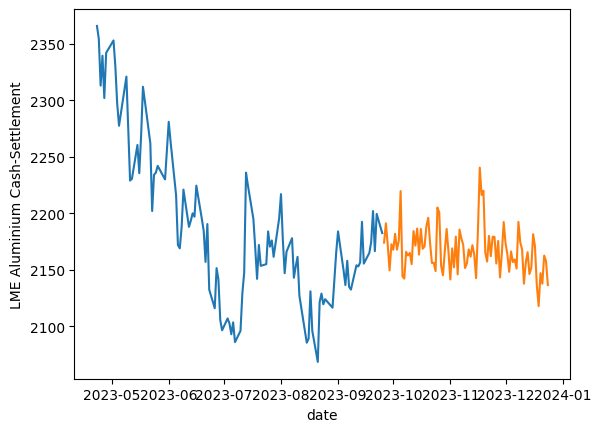

In [349]:
sns.lineplot(working_data.iloc[5500:, 0])
sns.lineplot(adj_df['Final_prognosis'])


---
---